In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import random

import geopandas as gpd
import rasterio
from rasterio.features import geometry_mask
from rasterio.mask import mask
from rasterio.sample import sample_gen
import rasterio.plot

from shapely.geometry import Point, box, Polygon

from sklearn.svm import OneClassSVM, SVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier, RandomForestClassifier
import xgboost as xgb

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, DepthwiseConv2D
from keras.layers import Activation, Input, Add, ZeroPadding2D, AveragePooling2D
from keras.initializers import glorot_uniform
from keras.layers import concatenate

from skimage.transform import resize


In [47]:

# Add persence point file file path
pfile = '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Crop Suitability Modeling/Data/strawb_points.csv'

#creates a pandas df
def create_df(file):
    df = pd.read_csv(file)
    return df

presences = create_df(pfile)

In [48]:
presences

,Species,Longitude,Latitude
0,221,-121.730795,41.829775
1,221,-122.345282,41.689828
2,221,-120.429168,41.572345
3,221,-121.114908,41.130171
4,221,-121.045248,41.139732
...,...,...,...
535,221,-118.015320,33.861685
536,221,-118.389675,33.752512
537,221,-118.020359,33.799740
538,221,-117.780775,33.674746


In [49]:
# presences.drop(columns=['pointid'], inplace=True)

In [50]:
presences.rename(columns={'SPECIES':'Species','LONGITUDE':'Longitude','LATITUDE':'Latitude'}, inplace=True)

In [51]:
def clip_raster_to_california(raster_path, output_path, california_boundary):
    with rasterio.open(raster_path) as src:
        out_image, out_transform = mask(src, [california_boundary], crop=True)
        out_meta = src.meta.copy()

        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })

        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(out_image)


In [52]:
california_counties = gpd.read_file('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Crop Suitability Modeling/Data/California_County_Boundaries.geojson')
california_boundary = california_counties.unary_union

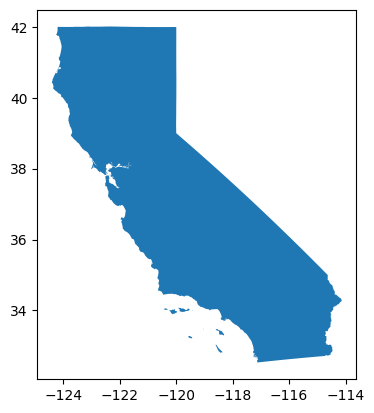

In [9]:
california_boundary_gdf = gpd.GeoDataFrame(geometry=[california_boundary], crs=california_counties.crs)

# Plotting
california_boundary_gdf.plot()
plt.show()

In [10]:
print(california_counties.crs)

EPSG:4326


In [10]:
# with rasterio.open('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Data/wc2.1_30s_bio/wc2.1_30s_bio_1.tif') as src:
#     print(src.crs)

EPSG:4326


# `Clip California from the geojson` - This is from WorldClim and not being used for modeling

### Test with 1 raster file 

In [132]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask

def clip_raster(raster_path, shapefile_path, output_path):
    # Load the shapefile
    shapefile = gpd.read_file(shapefile_path)

    # Load the raster
    with rasterio.open(raster_path) as src:
        out_image, out_transform = mask(src, shapes=shapefile.geometry, crop=True)
        out_meta = src.meta.copy()

        out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform})

        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(out_image)

# Example usage
raster_path = '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Data/wc2.1_30s_bio/wc2.1_30s_bio_1.tif'
shapefile_path = '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Data/California_County_Boundaries.geojson'
output_path = '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Data/californiaclipped_bio/calif_bio_001.tif'
clip_raster(raster_path, shapefile_path, output_path)


### Iterate over all the raster bio clim varibale files 

In [133]:
def process_worldclim_directory(source_dir, output_dir, california_boundary):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(source_dir):
        if filename.startswith('wc2.1_30s_bio_') and filename.endswith('.tif'):
            input_path = os.path.join(source_dir, filename)
            output_filename = 'calif_bio_' + filename.split('_')[3]  # Change filename format here
            output_path = os.path.join(output_dir, output_filename)

            clip_raster_to_california(input_path, output_path, california_boundary)
            print(f'Processed {output_filename}')


In [134]:
source_directory = '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Data/wc2.1_30s_bio'
output_directory = '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Data/californiaclipped_bio'

process_worldclim_directory(source_directory, output_directory, california_boundary)


Processed calif_bio_16.tif
Processed calif_bio_17.tif
Processed calif_bio_15.tif
Processed calif_bio_14.tif
Processed calif_bio_10.tif
Processed calif_bio_11.tif
Processed calif_bio_13.tif
Processed calif_bio_12.tif
Processed calif_bio_7.tif
Processed calif_bio_6.tif
Processed calif_bio_4.tif
Processed calif_bio_5.tif
Processed calif_bio_1.tif
Processed calif_bio_2.tif
Processed calif_bio_3.tif
Processed calif_bio_8.tif
Processed calif_bio_9.tif
Processed calif_bio_19.tif
Processed calif_bio_18.tif


### Generating dummy lat long values - Testing

In [128]:

def generate_random_coordinates(bounds, num_samples):
    min_lon, min_lat, max_lon, max_lat = bounds
    latitudes = [random.uniform(min_lat, max_lat) for _ in range(num_samples)]
    longitudes = [random.uniform(min_lon, max_lon) for _ in range(num_samples)]
    return latitudes, longitudes

# Bounds for California (min_longitude, min_latitude, max_longitude, max_latitude)
bounds = (-124.409591, 32.534156, -114.131211, 42.009518)

# Number of samples to generate
num_samples = 1000

# Generating random coordinates
latitudes, longitudes = generate_random_coordinates(bounds, num_samples)

# DataFrame to store 
df = pd.DataFrame({
    'Longitude': longitudes,
    'Latitude': latitudes
})

df


,Longitude,Latitude
0,-120.501830,35.666046
1,-114.715317,33.892661
2,-118.533214,35.306276
3,-117.771589,37.162667
4,-120.314298,37.256574
...,...,...
995,-114.759798,36.308124
996,-118.074404,40.885019
997,-119.278548,39.074890
998,-118.254964,34.563895


# **Implemenation Start**

# `Incorporating Presence Points with Bioclimatic Data`

In [53]:
def sample_raster_values(raster_path, presence_points):
    """
    Samples raster values at each coordinate in a Pandas dataframe.
    
    Parameters:
    -----------
    raster_path : str
        The path to the raster file.
    presence_points : pandas.DataFrame
        A Pandas dataframe with columns 'Longitude' and 'Latitude' containing the coordinates to sample.
        
    Returns:
    --------
    pandas.DataFrame
        A new Pandas dataframe with columns for each raster band containing the sampled values.
    """
    # Create an empty dataframe with the same index as presence_points
    bio_df = pd.DataFrame(index=presence_points.index)

    # Loop over each raster file
    for i in range(1, 20):
        filename = f'{raster_path}/bio_{i}.tif'

        # Open the raster file
        with rasterio.open(filename) as src:

            # Sample the raster at each coordinate in the dataframe
            values = []
            for idx, row in presence_points.iterrows():
                lon, lat = row['Longitude'], row['Latitude']
                result = list(src.sample([(lon, lat)]))

                # Extract the first and only value from the result if it's not None
                if result[0] is not None:
                    # Assuming result[0] is a one-element array, access the first element before converting
                    values.append(int(result[0][0]))  # Accessing the first element of the array
                else:
                    values.append('NA')


            # Add the values to the dataframe
            bio_df[f'bio_{i}'] = values
    
    return bio_df


In [54]:
bio_df = pd.DataFrame(columns=['bio_'+str(i) for i in range(1,20)]) #bio1-19
raster_path = '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Crop Suitability Modeling/Data/bioclims/californiaclipped'

In [55]:
bio_df

,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19


In [56]:
presence_bio_df = sample_raster_values(raster_path, presences)

In [57]:
presence_bio_df

,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
0,91,119,35,7289,292,-43,335,10,203,203,0,350,49,7,45,143,30,30,136
1,113,121,36,7102,309,-21,330,30,220,220,23,538,88,9,61,256,34,34,254
2,95,116,33,7895,302,-48,350,6,216,216,-4,399,56,7,48,163,28,28,162
3,103,120,34,7682,307,-40,347,5,219,219,5,413,62,5,55,185,20,20,185
4,102,120,34,7698,307,-41,348,5,219,219,5,388,55,5,51,164,21,21,164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,196,106,43,4728,327,83,244,142,253,265,135,343,79,0,97,221,1,2,207
536,174,90,44,3943,285,80,205,128,220,232,124,389,86,0,96,254,3,4,228
537,195,103,43,4603,323,85,238,142,250,262,136,331,76,0,97,214,1,2,199
538,192,101,43,4559,319,84,234,140,247,260,134,294,61,0,92,181,2,4,162


In [58]:
presence_bio_df = pd.concat([presences,presence_bio_df],axis=1) #pp+bio

In [59]:
presence_bio_df

,Species,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,...,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
0,221,-121.730795,41.829775,91,119,35,7289,292,-43,335,...,203,0,350,49,7,45,143,30,30,136
1,221,-122.345282,41.689828,113,121,36,7102,309,-21,330,...,220,23,538,88,9,61,256,34,34,254
2,221,-120.429168,41.572345,95,116,33,7895,302,-48,350,...,216,-4,399,56,7,48,163,28,28,162
3,221,-121.114908,41.130171,103,120,34,7682,307,-40,347,...,219,5,413,62,5,55,185,20,20,185
4,221,-121.045248,41.139732,102,120,34,7698,307,-41,348,...,219,5,388,55,5,51,164,21,21,164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,221,-118.015320,33.861685,196,106,43,4728,327,83,244,...,265,135,343,79,0,97,221,1,2,207
536,221,-118.389675,33.752512,174,90,44,3943,285,80,205,...,232,124,389,86,0,96,254,3,4,228
537,221,-118.020359,33.799740,195,103,43,4603,323,85,238,...,262,136,331,76,0,97,214,1,2,199
538,221,-117.780775,33.674746,192,101,43,4559,319,84,234,...,260,134,294,61,0,92,181,2,4,162


In [60]:
presence_bio_df.to_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Crop Suitability Modeling/Data/saved_csv/straw_pres_bio_df.csv',index=False)

### OCSVM - Pseudoabsence data generation 

In [61]:
import numpy as np

# Assuming -3.4e38 is the NoData value
no_data_value = -339999995214436424907732413799364296704
presence_bio_df.replace(no_data_value, np.nan, inplace=True)

In [62]:
presence_bio_df.dropna(inplace=True)

In [63]:
presence_bio_df.iloc[:, 3:]

,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
0,91,119,35,7289,292,-43,335,10,203,203,0,350,49,7,45,143,30,30,136
1,113,121,36,7102,309,-21,330,30,220,220,23,538,88,9,61,256,34,34,254
2,95,116,33,7895,302,-48,350,6,216,216,-4,399,56,7,48,163,28,28,162
3,103,120,34,7682,307,-40,347,5,219,219,5,413,62,5,55,185,20,20,185
4,102,120,34,7698,307,-41,348,5,219,219,5,388,55,5,51,164,21,21,164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,196,106,43,4728,327,83,244,142,253,265,135,343,79,0,97,221,1,2,207
536,174,90,44,3943,285,80,205,128,220,232,124,389,86,0,96,254,3,4,228
537,195,103,43,4603,323,85,238,142,250,262,136,331,76,0,97,214,1,2,199
538,192,101,43,4559,319,84,234,140,247,260,134,294,61,0,92,181,2,4,162


In [64]:
# Normalize the data to feed ocsvm
X = presence_bio_df.iloc[:,3:].values

# Standardize the bioclimatic data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [65]:
nu_s=[0.01,0.05,0.1,0.5] #hyperparameter

# Train OCSVM model using presence data nu=0.01
ocsvm_m1 = OneClassSVM(nu=nu_s[0])
ocsvm_m1.fit(X)

# Train OCSVM model using presence data nu=0.05
ocsvm_m2 = OneClassSVM(nu=nu_s[1])
ocsvm_m2.fit(X)

# Train OCSVM model using presence data nu=0.1
ocsvm_m3 = OneClassSVM(nu=nu_s[2])
ocsvm_m3.fit(X)


ocsvm_m4 = OneClassSVM(nu=nu_s[3])
ocsvm_m4.fit(X)

OneClassSVM()

In [66]:
def generate_pseudoabsences(polygon, n_pseudoabsences):
    """
    Generates pseudoabsence points within a polygon.
    
    Parameters:
    -----------
    polygon : shapely.geometry.Polygon
        The polygon in which to generate the pseudoabsences.
    n_pseudoabsences : int
        The number of pseudoabsences to generate.
        
    Returns:
    --------
    list
        A list of tuples, where each tuple contains the x and y coordinates of a pseudoabsence point.
    """
    # Define the extent of the polygon
    min_x, min_y, max_x, max_y = polygon.bounds

    # Generate the pseudoabsences
    pseudoabsences = []
    while len(pseudoabsences) < n_pseudoabsences:
        # Generate a random point within the extent of the polygon
        x = random.uniform(min_x, max_x)
        y = random.uniform(min_y, max_y)
        point = Point(x, y)

        # Check if the point is within the polygon
        if polygon.contains(point):
            pseudoabsences.append((x, y))
    
    return pseudoabsences

In [67]:
# Bounding box coordinates for entire California
min_lon, min_lat = -124.409591, 32.534156
max_lon, max_lat = -114.131211, 42.009518

# Created a polygon using the bounding box coordinates
cali_sm2_loc = Polygon([(min_lon, min_lat), (min_lon, max_lat), (max_lon, max_lat), (max_lon, min_lat)])

pseudoabsences = generate_pseudoabsences(cali_sm2_loc,n_pseudoabsences=2000)

In [68]:
pseudoabsences

[(-122.15966637566308, 36.49099303387014),
 (-120.0781188482894, 32.65233640105544),
 (-122.76103805418192, 36.83457018854132),
 (-118.66304143724865, 38.29090655792333),
 (-123.80592588077305, 38.64105147317174),
 (-114.47852518508701, 40.46169601476207),
 (-117.1012760518718, 35.647127567465446),
 (-116.08087051959411, 41.701389152011615),
 (-121.75815459206419, 40.22493942380285),
 (-120.45116335179483, 41.049466727600766),
 (-118.62887094116893, 34.79677632115799),
 (-117.56701662200054, 41.24142517795049),
 (-115.94530396608272, 39.99703150624401),
 (-119.25629685037609, 33.63821730613217),
 (-117.54859176881723, 35.40824538459054),
 (-120.19596333444503, 35.589983304791204),
 (-123.20806436317154, 39.17181271810192),
 (-121.42686038604168, 38.307819298577506),
 (-120.12379638481919, 34.15784291951802),
 (-116.97603626727879, 35.81979826100179),
 (-117.02427300665154, 33.33400178426328),
 (-122.69858798645636, 38.2163456717797),
 (-116.50749145032142, 35.163379384721004),
 (-122.3

In [69]:
# Created a df containing pseudoabs+biovars
pseudoabsences_df = pd.DataFrame({'Longitude': [x[0] for x in pseudoabsences],
                                  'Latitude': [x[1] for x in pseudoabsences]})


In [70]:
pseudoabsences_df

,Longitude,Latitude
0,-122.159666,36.490993
1,-120.078119,32.652336
2,-122.761038,36.834570
3,-118.663041,38.290907
4,-123.805926,38.641051
...,...,...
1995,-115.330259,39.005298
1996,-119.241596,35.655648
1997,-123.751473,37.303537
1998,-122.051283,39.726737


In [71]:
# Incorporating background points with bio climatic raster data 
pseudoabsences_bio_df=sample_raster_values(raster_path,pseudoabsences_df)
pseudoabsences_bio_df=pd.concat([pseudoabsences_df,pseudoabsences_bio_df],axis=1)

In [72]:
pseudoabsences_bio_df

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
0,-122.159666,36.490993,-32768,255,127,65535,-32768,-32768,65535,-32768,...,-32768,-32768,65535,65535,65535,65535,65535,65535,65535,65535
1,-120.078119,32.652336,-32768,255,127,65535,-32768,-32768,65535,-32768,...,-32768,-32768,65535,65535,65535,65535,65535,65535,65535,65535
2,-122.761038,36.834570,-32768,255,127,65535,-32768,-32768,65535,-32768,...,-32768,-32768,65535,65535,65535,65535,65535,65535,65535,65535
3,-118.663041,38.290907,-32768,255,127,65535,-32768,-32768,65535,-32768,...,-32768,-32768,65535,65535,65535,65535,65535,65535,65535,65535
4,-123.805926,38.641051,-32768,255,127,65535,-32768,-32768,65535,-32768,...,-32768,-32768,65535,65535,65535,65535,65535,65535,65535,65535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-115.330259,39.005298,-32768,255,127,65535,-32768,-32768,65535,-32768,...,-32768,-32768,65535,65535,65535,65535,65535,65535,65535,65535
1996,-119.241596,35.655648,198,130,40,6594,378,56,322,124,...,295,114,190,34,0,81,102,2,2,92
1997,-123.751473,37.303537,-32768,255,127,65535,-32768,-32768,65535,-32768,...,-32768,-32768,65535,65535,65535,65535,65535,65535,65535,65535
1998,-122.051283,39.726737,178,122,37,6950,368,41,327,87,...,277,87,597,125,1,84,356,9,9,356


In [73]:
# pseudoabsences_bio_df=pseudoabsences_bio_df.replace((-339999995214436424907732413799364296704),np.nan)

pseudoabsences_bio_df=pseudoabsences_bio_df.replace((-32768, 65535),np.nan)

pseudoabsences_bio_df=pseudoabsences_bio_df.dropna()

pseudoabsences_bio_df

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
6,-117.101276,35.647128,192.0,123,34,8255.0,387.0,26.0,361.0,95.0,...,308.0,81.0,96.0,19.0,1.0,72.0,56.0,5.0,20.0,48.0
8,-121.758155,40.224939,117.0,122,36,7170.0,311.0,-21.0,333.0,25.0,...,222.0,25.0,1119.0,195.0,4.0,72.0,568.0,26.0,26.0,568.0
9,-120.451163,41.049467,81.0,118,33,7823.0,286.0,-64.0,350.0,-12.0,...,200.0,-18.0,352.0,43.0,7.0,40.0,129.0,30.0,30.0,129.0
10,-118.628871,34.796776,154.0,126,41,6137.0,321.0,18.0,302.0,83.0,...,243.0,75.0,281.0,57.0,1.0,87.0,167.0,3.0,7.0,143.0
14,-117.548592,35.408245,166.0,126,36,7724.0,357.0,10.0,347.0,76.0,...,277.0,65.0,128.0,26.0,1.0,77.0,77.0,4.0,14.0,62.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1988,-120.204072,34.826857,156.0,99,45,4002.0,275.0,57.0,218.0,110.0,...,214.0,104.0,427.0,84.0,0.0,89.0,247.0,1.0,2.0,215.0
1989,-118.645824,34.191884,178.0,106,43,4763.0,310.0,67.0,243.0,123.0,...,248.0,118.0,362.0,85.0,0.0,100.0,243.0,1.0,2.0,228.0
1991,-122.462993,37.614419,138.0,68,46,2683.0,217.0,69.0,148.0,99.0,...,173.0,99.0,698.0,137.0,2.0,85.0,387.0,9.0,9.0,387.0
1996,-119.241596,35.655648,198.0,130,40,6594.0,378.0,56.0,322.0,124.0,...,295.0,114.0,190.0,34.0,0.0,81.0,102.0,2.0,2.0,92.0


In [74]:
# Extract only bioclimatic data for the presence points
x = pseudoabsences_bio_df.iloc[:, 2:].values

# Standardize the bioclimatic data
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

In [75]:
# suitable points (1) unsuitable (-1)
pseudo_absences_m1 = pseudoabsences_bio_df.loc[ocsvm_m1.predict(x) == -1] #0.01

pseudo_absences_m2 = pseudoabsences_bio_df.loc[ocsvm_m2.predict(x) == -1] #0.05

pseudo_absences_m3 = pseudoabsences_bio_df.loc[ocsvm_m3.predict(x) == -1] #0.1

pseudo_absences_m4 = pseudoabsences_bio_df.loc[ocsvm_m4.predict(x) == -1] #0.1

In [76]:
# print("Unsuitable points detected with ocsvm model 1 with nu = 0.01 :", pseudo_absences_m1.shape[0])
# print("Unsuitable points detected with ocsvm model 2 with nu = 0.05 :", pseudo_absences_m2.shape[0])
print("Unsuitable points detected with ocsvm model 3 with nu = 0.1 :", pseudo_absences_m3.shape[0])
print("Unsuitable points detected with ocsvm model 4 with nu = 0.5 :", pseudo_absences_m4.shape[0])

Unsuitable points detected with ocsvm model 3 with nu = 0.1 : 721
Unsuitable points detected with ocsvm model 4 with nu = 0.5 : 874


In [77]:
pseudo_absences_m3.to_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Crop Suitability Modeling/Data/saved_csv/unsuitable_ocsvm_m3_str.csv',index=False)
pseudo_absences_m4.to_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Crop Suitability Modeling/Data/saved_csv/unsuitable_ocsvm_m4_str.csv',index=False)

In [78]:
# suitable points (1) unsuitable (-1)
suitable_m1 = pseudoabsences_bio_df.loc[ocsvm_m1.predict(x) == 1]
suitable_m2 = pseudoabsences_bio_df.loc[ocsvm_m2.predict(x) == 1]
suitable_m3 = pseudoabsences_bio_df.loc[ocsvm_m3.predict(x) == 1]

print("Suitable points detected with ocsvm model 1 with nu = 0.01 :", suitable_m1.shape[0])
print("Suitable points detected with ocsvm model 2 with nu = 0.05 :", suitable_m2.shape[0])
print("Suitable points detected with ocsvm model 3 with nu = 0.1 :", suitable_m3.shape[0])

Suitable points detected with ocsvm model 1 with nu = 0.01 : 460
Suitable points detected with ocsvm model 2 with nu = 0.05 : 387
Suitable points detected with ocsvm model 3 with nu = 0.1 : 153


In [79]:
suitable_m3.to_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Crop Suitability Modeling/Data/saved_csv/suitable_ocsvm_m3_str.csv',index=False)

***

# `Methodology - Boosting` - Not being used as part of modeling ** Not part of implementation

In [38]:
# ! pip3 install xgboost shapely geopandas fiona

In [39]:
# Load bioclimatic variables data
bioclim_data = []
for i in range(1, 20):
    file_name = "/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Crop Suitability Modeling/Data/bioclims/californiaclipped/bio_" + str(i) + ".tif"
    with rasterio.open(file_name) as src:
        data = src.read(1).astype(np.float32)
        # Mask out nodata values
        data = np.ma.masked_equal(data, src.nodata)
        bioclim_data.append(data)

env_data = np.stack(bioclim_data, axis=2)

In [40]:
bioclim_data

[masked_array(
   data=[[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],
   mask=[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]],
   fill_value=-32768.0,
   dtype=float32),
 masked_array(
   data=[[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],
   mask=[[ True,  True,  True, ...,  True,  True,  Tru

In [41]:
env_data

masked_array(
  data=[[[-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         [-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         [-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         ...,
         [-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         [-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         [-32768.,    255.,    127., ...,  65535.,  65535.,  65535.]],

        [[-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         [-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         [-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         ...,
         [-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         [-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         [-32768.,    255.,    127., ...,  65535.,  65535.,  65535.]],

        [[-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         [-32768.,    255.,    127., ...,  6

## `New Pseudoabsence Generation Method`

In [42]:
def generate_target_background(presence_points_df, study_area, n_samples=1000):
    # Presence points are in GeoDataFrame format
    if not isinstance(presence_points_df, gpd.GeoDataFrame):
        # Converting to GeoDataFrame assuming 'Longitude' and 'Latitude' columns
        presence_points_df = gpd.GeoDataFrame(
            presence_points_df, 
            geometry=gpd.points_from_xy(presence_points_df.Longitude, presence_points_df.Latitude)
        )

    background_points = []
    minx, miny, maxx, maxy = study_area.bounds  # Unpacking the bounds directly

    while len(background_points) < n_samples:
        # Randomly generated a point within the extent of the study area
        x = random.uniform(minx, maxx)
        y = random.uniform(miny, maxy)
        point = Point(x, y)

        # Ensured the point is not in any presence points and is within the study area
        if study_area.contains(point) and not presence_points_df.contains(point).any():
            background_points.append((x, y))

    # Convert -> DataFrame -> GeoDataFrame
    background_points_df = pd.DataFrame(background_points, columns=['Longitude', 'Latitude'])
    return gpd.GeoDataFrame(background_points_df, geometry=gpd.points_from_xy(background_points_df.Longitude, background_points_df.Latitude))

# Defined the bounding box coordinates for California
california_bounds = (-124.409591, 32.534156, -114.131211, 42.009518)
california_polygon = Polygon([(california_bounds[0], california_bounds[1]), 
                              (california_bounds[0], california_bounds[3]), 
                              (california_bounds[2], california_bounds[3]), 
                              (california_bounds[2], california_bounds[1])])

# Generate background points
background_points = generate_target_background(presences, california_polygon, n_samples=2000)


In [43]:
background_points

,Longitude,Latitude,geometry
0,-123.839287,34.100160,POINT (-123.83929 34.10016)
1,-118.068536,32.739469,POINT (-118.06854 32.73947)
2,-114.926307,36.348826,POINT (-114.92631 36.34883)
3,-123.079019,38.039132,POINT (-123.07902 38.03913)
4,-118.598248,33.170139,POINT (-118.59825 33.17014)
...,...,...,...
1995,-114.636426,35.691770,POINT (-114.63643 35.69177)
1996,-115.755836,41.511948,POINT (-115.75584 41.51195)
1997,-116.605806,41.849291,POINT (-116.60581 41.84929)
1998,-120.664976,36.672540,POINT (-120.66498 36.67254)


In [67]:
raster_path = '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Crop Suitability Modeling/Data/bioclims/californiaclipped'

In [68]:
pseudoabsences_bio_df2=sample_raster_values(raster_path,background_points[['Longitude','Latitude']])
pseudoabsences_bio_df2

,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
0,201,130,36,7741,393,39,354,112,265,311,98,102,15,1,54,46,4,23,44
1,134,125,46,4786,285,13,271,78,196,200,68,346,70,1,89,200,3,3,197
2,-32768,255,127,65535,-32768,-32768,65535,-32768,-32768,-32768,-32768,65535,65535,65535,65535,65535,65535,65535,65535
3,210,132,37,7571,398,49,348,192,271,317,109,106,16,1,53,45,4,42,43
4,-32768,255,127,65535,-32768,-32768,65535,-32768,-32768,-32768,-32768,65535,65535,65535,65535,65535,65535,65535,65535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-32768,255,127,65535,-32768,-32768,65535,-32768,-32768,-32768,-32768,65535,65535,65535,65535,65535,65535,65535,65535
1996,211,119,32,8635,409,42,367,111,284,333,96,80,13,1,60,41,5,17,34
1997,-32768,255,127,65535,-32768,-32768,65535,-32768,-32768,-32768,-32768,65535,65535,65535,65535,65535,65535,65535,65535
1998,184,129,42,5871,356,51,305,113,261,268,106,270,49,0,84,144,1,2,144


In [69]:
pseudoabsences_bio_df2=pd.concat([background_points[['Longitude','Latitude']],pseudoabsences_bio_df2],axis=1)

In [70]:
pseudoabsences_bio_df2

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
0,-116.846648,34.898844,201,130,36,7741,393,39,354,112,...,311,98,102,15,1,54,46,4,23,44
1,-120.981408,36.451637,134,125,46,4786,285,13,271,78,...,200,68,346,70,1,89,200,3,3,197
2,-118.731450,33.023051,-32768,255,127,65535,-32768,-32768,65535,-32768,...,-32768,-32768,65535,65535,65535,65535,65535,65535,65535,65535
3,-115.599255,34.178419,210,132,37,7571,398,49,348,192,...,317,109,106,16,1,53,45,4,42,43
4,-115.820752,40.413981,-32768,255,127,65535,-32768,-32768,65535,-32768,...,-32768,-32768,65535,65535,65535,65535,65535,65535,65535,65535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-121.433844,34.378767,-32768,255,127,65535,-32768,-32768,65535,-32768,...,-32768,-32768,65535,65535,65535,65535,65535,65535,65535,65535
1996,-117.343069,36.155797,211,119,32,8635,409,42,367,111,...,333,96,80,13,1,60,41,5,17,34
1997,-122.721108,35.734169,-32768,255,127,65535,-32768,-32768,65535,-32768,...,-32768,-32768,65535,65535,65535,65535,65535,65535,65535,65535
1998,-120.345522,37.033259,184,129,42,5871,356,51,305,113,...,268,106,270,49,0,84,144,1,2,144


In [71]:
# pseudoabsences_bio_df=pseudoabsences_bio_df.replace((-339999995214436424907732413799364296704),np.nan)

pseudoabsences_bio_df2=pseudoabsences_bio_df2.replace((-32768, 65535),np.nan)

pseudoabsences_bio_df2=pseudoabsences_bio_df2.dropna()

pseudoabsences_bio_df2

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
0,-116.846648,34.898844,201.0,130,36,7741.0,393.0,39.0,354.0,112.0,...,311.0,98.0,102.0,15.0,1.0,54.0,46.0,4.0,23.0,44.0
1,-120.981408,36.451637,134.0,125,46,4786.0,285.0,13.0,271.0,78.0,...,200.0,68.0,346.0,70.0,1.0,89.0,200.0,3.0,3.0,197.0
3,-115.599255,34.178419,210.0,132,37,7571.0,398.0,49.0,348.0,192.0,...,317.0,109.0,106.0,16.0,1.0,53.0,45.0,4.0,42.0,43.0
5,-120.113813,41.183995,73.0,116,32,7930.0,279.0,-73.0,352.0,-21.0,...,193.0,-28.0,253.0,31.0,6.0,38.0,92.0,22.0,22.0,92.0
9,-122.684937,39.577123,96.0,117,40,5872.0,266.0,-25.0,291.0,18.0,...,180.0,18.0,815.0,184.0,2.0,88.0,511.0,12.0,12.0,511.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1987,-122.375355,39.857549,167.0,121,37,6815.0,355.0,33.0,322.0,78.0,...,265.0,78.0,567.0,116.0,2.0,82.0,325.0,10.0,10.0,325.0
1989,-115.010201,34.338990,234.0,129,36,7939.0,423.0,68.0,355.0,332.0,...,346.0,128.0,107.0,17.0,1.0,50.0,43.0,5.0,43.0,36.0
1992,-116.133956,32.641020,158.0,133,44,5692.0,321.0,24.0,296.0,88.0,...,242.0,85.0,273.0,54.0,2.0,70.0,141.0,9.0,46.0,140.0
1996,-117.343069,36.155797,211.0,119,32,8635.0,409.0,42.0,367.0,111.0,...,333.0,96.0,80.0,13.0,1.0,60.0,41.0,5.0,17.0,34.0


In [72]:
def extract_environmental_variables(points, env_data, affine_transform):
    variables = []
    for point in points:
        # Point is a Shapely Point or a tuple of coordinates (x, y)
        if isinstance(point, tuple):
            x, y = point
        elif isinstance(point, Point):
            x, y = point.x, point.y
        else:
            raise ValueError("Point is neither a tuple nor a shapely Point.")
        
        # Converted geographic coordinates to pixel coordinates
        row, col = ~affine_transform * (x, y)
        row, col = int(row), int(col)  # Convert to integer for indexing

        # Extracted the data for all layers at this point, ensuring we're within bounds
        if 0 <= row < env_data.shape[0] and 0 <= col < env_data.shape[1]:
            data = env_data[row, col, :]
            variables.append(data)
        else:
            # Handled cases where point is out of bounds
            variables.append([np.nan] * env_data.shape[2])  
    return np.array(variables)

In [73]:
# Converted DataFrame to list of tuples or Shapely Points
presence_tuples = list(zip(presences['Longitude'], presences['Latitude']))
presence_points = [Point(xy) for xy in zip(presences['Longitude'], presences['Latitude'])]

background_tuples = list(zip(background_points['Longitude'], background_points['Latitude']))
background_points = [Point(xy) for xy in zip(background_points['Longitude'], background_points['Latitude'])]

In [74]:
X_presence = extract_environmental_variables(presence_points, env_data, src.transform)
X_background = extract_environmental_variables(background_points, env_data, src.transform)

y_presence = [1] * len(X_presence)
y_background = [0] * len(X_background)

X = pd.concat([pd.DataFrame(X_presence), pd.DataFrame(X_background)])
y = y_presence + y_background

In [75]:
# presence_bio_df.drop(columns=['Species'],inplace=True)

In [76]:
presence_bio_df['presence']=1
pseudoabsences_bio_df2['presence']=0

In [77]:
presence_bio_df

,Species,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,...,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19,presence
0,221,-121.730795,41.829775,91,119,35,7289,292,-43,335,...,0,350,49,7,45,143,30,30,136,1
1,221,-122.345282,41.689828,113,121,36,7102,309,-21,330,...,23,538,88,9,61,256,34,34,254,1
2,221,-120.429168,41.572345,95,116,33,7895,302,-48,350,...,-4,399,56,7,48,163,28,28,162,1
3,221,-121.114908,41.130171,103,120,34,7682,307,-40,347,...,5,413,62,5,55,185,20,20,185,1
4,221,-121.045248,41.139732,102,120,34,7698,307,-41,348,...,5,388,55,5,51,164,21,21,164,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,221,-118.015320,33.861685,196,106,43,4728,327,83,244,...,135,343,79,0,97,221,1,2,207,1
536,221,-118.389675,33.752512,174,90,44,3943,285,80,205,...,124,389,86,0,96,254,3,4,228,1
537,221,-118.020359,33.799740,195,103,43,4603,323,85,238,...,136,331,76,0,97,214,1,2,199,1
538,221,-117.780775,33.674746,192,101,43,4559,319,84,234,...,134,294,61,0,92,181,2,4,162,1


In [78]:
pseudoabsences_bio_df2

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19,presence
0,-116.846648,34.898844,201.0,130,36,7741.0,393.0,39.0,354.0,112.0,...,98.0,102.0,15.0,1.0,54.0,46.0,4.0,23.0,44.0,0
1,-120.981408,36.451637,134.0,125,46,4786.0,285.0,13.0,271.0,78.0,...,68.0,346.0,70.0,1.0,89.0,200.0,3.0,3.0,197.0,0
3,-115.599255,34.178419,210.0,132,37,7571.0,398.0,49.0,348.0,192.0,...,109.0,106.0,16.0,1.0,53.0,45.0,4.0,42.0,43.0,0
5,-120.113813,41.183995,73.0,116,32,7930.0,279.0,-73.0,352.0,-21.0,...,-28.0,253.0,31.0,6.0,38.0,92.0,22.0,22.0,92.0,0
9,-122.684937,39.577123,96.0,117,40,5872.0,266.0,-25.0,291.0,18.0,...,18.0,815.0,184.0,2.0,88.0,511.0,12.0,12.0,511.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1987,-122.375355,39.857549,167.0,121,37,6815.0,355.0,33.0,322.0,78.0,...,78.0,567.0,116.0,2.0,82.0,325.0,10.0,10.0,325.0,0
1989,-115.010201,34.338990,234.0,129,36,7939.0,423.0,68.0,355.0,332.0,...,128.0,107.0,17.0,1.0,50.0,43.0,5.0,43.0,36.0,0
1992,-116.133956,32.641020,158.0,133,44,5692.0,321.0,24.0,296.0,88.0,...,85.0,273.0,54.0,2.0,70.0,141.0,9.0,46.0,140.0,0
1996,-117.343069,36.155797,211.0,119,32,8635.0,409.0,42.0,367.0,111.0,...,96.0,80.0,13.0,1.0,60.0,41.0,5.0,17.0,34.0,0


In [85]:
presence_bio_df.iloc[:,3:22].values

array([[ 91, 119,  35, ...,  30,  30, 136],
       [113, 121,  36, ...,  34,  34, 254],
       [ 95, 116,  33, ...,  28,  28, 162],
       ...,
       [195, 103,  43, ...,   1,   2, 199],
       [192, 101,  43, ...,   2,   4, 162],
       [181, 102,  43, ...,   4,   5, 174]])

In [81]:
presence_bio_df.iloc[:, 22].values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [87]:
pre_pseu_df = pd.concat([presence_bio_df.drop(columns=['Species']), pseudoabsences_bio_df2])

In [88]:
pre_pseu_df

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19,presence
0,-121.730795,41.829775,91.0,119,35,7289.0,292.0,-43.0,335.0,10.0,...,0.0,350.0,49.0,7.0,45.0,143.0,30.0,30.0,136.0,1
1,-122.345282,41.689828,113.0,121,36,7102.0,309.0,-21.0,330.0,30.0,...,23.0,538.0,88.0,9.0,61.0,256.0,34.0,34.0,254.0,1
2,-120.429168,41.572345,95.0,116,33,7895.0,302.0,-48.0,350.0,6.0,...,-4.0,399.0,56.0,7.0,48.0,163.0,28.0,28.0,162.0,1
3,-121.114908,41.130171,103.0,120,34,7682.0,307.0,-40.0,347.0,5.0,...,5.0,413.0,62.0,5.0,55.0,185.0,20.0,20.0,185.0,1
4,-121.045248,41.139732,102.0,120,34,7698.0,307.0,-41.0,348.0,5.0,...,5.0,388.0,55.0,5.0,51.0,164.0,21.0,21.0,164.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1987,-122.375355,39.857549,167.0,121,37,6815.0,355.0,33.0,322.0,78.0,...,78.0,567.0,116.0,2.0,82.0,325.0,10.0,10.0,325.0,0
1989,-115.010201,34.338990,234.0,129,36,7939.0,423.0,68.0,355.0,332.0,...,128.0,107.0,17.0,1.0,50.0,43.0,5.0,43.0,36.0,0
1992,-116.133956,32.641020,158.0,133,44,5692.0,321.0,24.0,296.0,88.0,...,85.0,273.0,54.0,2.0,70.0,141.0,9.0,46.0,140.0,0
1996,-117.343069,36.155797,211.0,119,32,8635.0,409.0,42.0,367.0,111.0,...,96.0,80.0,13.0,1.0,60.0,41.0,5.0,17.0,34.0,0


In [89]:
pre_pseu_df.reset_index(drop=True, inplace=True)

In [91]:
X = pre_pseu_df.iloc[:, :-1]
y = pre_pseu_df['presence']

In [92]:
pre_pseu_df.iloc[:, :-1]

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
0,-121.730795,41.829775,91.0,119,35,7289.0,292.0,-43.0,335.0,10.0,...,203.0,0.0,350.0,49.0,7.0,45.0,143.0,30.0,30.0,136.0
1,-122.345282,41.689828,113.0,121,36,7102.0,309.0,-21.0,330.0,30.0,...,220.0,23.0,538.0,88.0,9.0,61.0,256.0,34.0,34.0,254.0
2,-120.429168,41.572345,95.0,116,33,7895.0,302.0,-48.0,350.0,6.0,...,216.0,-4.0,399.0,56.0,7.0,48.0,163.0,28.0,28.0,162.0
3,-121.114908,41.130171,103.0,120,34,7682.0,307.0,-40.0,347.0,5.0,...,219.0,5.0,413.0,62.0,5.0,55.0,185.0,20.0,20.0,185.0
4,-121.045248,41.139732,102.0,120,34,7698.0,307.0,-41.0,348.0,5.0,...,219.0,5.0,388.0,55.0,5.0,51.0,164.0,21.0,21.0,164.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1397,-122.375355,39.857549,167.0,121,37,6815.0,355.0,33.0,322.0,78.0,...,265.0,78.0,567.0,116.0,2.0,82.0,325.0,10.0,10.0,325.0
1398,-115.010201,34.338990,234.0,129,36,7939.0,423.0,68.0,355.0,332.0,...,346.0,128.0,107.0,17.0,1.0,50.0,43.0,5.0,43.0,36.0
1399,-116.133956,32.641020,158.0,133,44,5692.0,321.0,24.0,296.0,88.0,...,242.0,85.0,273.0,54.0,2.0,70.0,141.0,9.0,46.0,140.0
1400,-117.343069,36.155797,211.0,119,32,8635.0,409.0,42.0,367.0,111.0,...,333.0,96.0,80.0,13.0,1.0,60.0,41.0,5.0,17.0,34.0


In [93]:
import xgboost as xgb

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100)
model.fit(X_train.drop(columns=['Longitude','Latitude']), y_train)

predictions = model.predict(X_test.drop(columns=['Longitude','Latitude']))

In [94]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.838479809976247


In [95]:
print("length of y_test:", len(y_test))
print("length of X_test:", len(X_test))
print("length of predictions:", len(predictions))
print("length of pre_pseu_df.loc[original_indices, 'Longitude'].values:", len(pre_pseu_df.loc[X_test.index , 'Longitude'].values))


length of y_test: 421
length of X_test: 421
length of predictions: 421
length of pre_pseu_df.loc[original_indices, 'Longitude'].values: 421


In [96]:
# Function to check validation of predictions 
def create_predictions_dataframe(X_test, y_test, predictions, original_df, test_indices):
    X_test_df = pd.DataFrame(X_test, columns=original_df.columns[2:-1])
    
    X_test_df['Predictions'] = predictions
    X_test_df['y_test'] = y_test.values
    
    X_test_df['Longitude'] = original_df.loc[test_indices, 'Longitude'].values
    X_test_df['Latitude'] = original_df.loc[test_indices, 'Latitude'].values
    
    # Ensured the index matches the original DataFrame's index
    X_test_df.index = test_indices
    
    # Reordered columns to match the original DataFrame, with 'Predictions' at the end
    columns_order = ['Longitude', 'Latitude'] + list(original_df.columns[2:-1]) + ['y_test'] +['Predictions']
    X_test_df = X_test_df[columns_order]
    
    return X_test_df


X_test_df = create_predictions_dataframe(X_test, y_test, predictions, pre_pseu_df, X_test.index)


In [97]:
X_test_df
# X_test_df[X_test_df['y_test']==X_test_df['Predictions']]

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19,y_test,Predictions
1093,-123.600411,39.852851,119.0,94,40,4684.0,254.0,23.0,231.0,59.0,...,1475.0,298.0,2.0,89.0,873.0,12.0,22.0,873.0,0,0
948,-120.757445,36.671299,141.0,129,44,5187.0,301.0,14.0,287.0,71.0,...,283.0,58.0,0.0,86.0,163.0,2.0,2.0,163.0,0,1
49,-121.974193,38.154507,162.0,110,44,4608.0,300.0,52.0,248.0,97.0,...,481.0,103.0,0.0,90.0,293.0,2.0,2.0,293.0,1,1
1258,-118.260842,35.727108,125.0,125,37,7250.0,309.0,-22.0,332.0,41.0,...,309.0,58.0,3.0,80.0,172.0,9.0,18.0,161.0,0,0
706,-115.757093,33.024451,237.0,136,41,6728.0,417.0,87.0,330.0,149.0,...,70.0,12.0,0.0,61.0,35.0,1.0,19.0,35.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,-120.513604,36.722406,178.0,131,43,5614.0,346.0,45.0,300.0,102.0,...,219.0,43.0,0.0,85.0,124.0,1.0,2.0,124.0,1,1
1351,-123.122160,39.368119,135.0,102,40,5063.0,280.0,28.0,251.0,68.0,...,1064.0,205.0,1.0,88.0,609.0,10.0,11.0,609.0,0,0
1165,-121.976553,38.455698,164.0,115,42,5123.0,315.0,46.0,269.0,92.0,...,550.0,130.0,0.0,97.0,363.0,3.0,3.0,363.0,0,1
294,-119.889752,36.787254,189.0,129,41,6265.0,367.0,52.0,315.0,118.0,...,269.0,50.0,0.0,84.0,146.0,0.0,0.0,144.0,1,0


In [98]:
X_test_df[X_test_df['y_test']==1]

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19,y_test,Predictions
49,-121.974193,38.154507,162.0,110,44,4608.0,300.0,52.0,248.0,97.0,...,481.0,103.0,0.0,90.0,293.0,2.0,2.0,293.0,1,1
342,-119.436481,36.444331,196.0,128,39,6617.0,377.0,55.0,322.0,119.0,...,287.0,57.0,0.0,85.0,157.0,0.0,0.0,157.0,1,1
344,-119.638559,36.386672,193.0,131,40,6404.0,372.0,52.0,319.0,120.0,...,232.0,45.0,0.0,85.0,128.0,0.0,0.0,124.0,1,0
306,-121.263636,36.399121,161.0,115,46,4256.0,296.0,50.0,245.0,107.0,...,376.0,76.0,1.0,89.0,214.0,3.0,3.0,212.0,1,1
29,-122.904802,38.092215,140.0,70,44,3052.0,226.0,65.0,160.0,96.0,...,1053.0,221.0,1.0,88.0,623.0,10.0,10.0,623.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,-120.341664,36.193328,169.0,133,44,5596.0,336.0,34.0,302.0,105.0,...,236.0,51.0,1.0,93.0,146.0,3.0,3.0,143.0,1,0
124,-120.964619,37.827033,175.0,123,42,5472.0,337.0,50.0,287.0,101.0,...,359.0,68.0,1.0,82.0,193.0,3.0,3.0,193.0,1,1
178,-120.597870,37.536506,179.0,125,42,5755.0,347.0,50.0,297.0,102.0,...,397.0,80.0,0.0,87.0,229.0,2.0,2.0,229.0,1,1
287,-120.513604,36.722406,178.0,131,43,5614.0,346.0,45.0,300.0,102.0,...,219.0,43.0,0.0,85.0,124.0,1.0,2.0,124.0,1,1


***

# `Isolation Forest - Pseudoabsence Generation` - New Method after OCSVM (Part of Implementation)

In [80]:
def generate_target_background(presence_points_df, study_area, n_samples=1000):
    # Presence points are in GeoDataFrame format
    if not isinstance(presence_points_df, gpd.GeoDataFrame):
        # Converting to GeoDataFrame assuming 'Longitude' and 'Latitude' columns
        presence_points_df = gpd.GeoDataFrame(
            presence_points_df, 
            geometry=gpd.points_from_xy(presence_points_df.Longitude, presence_points_df.Latitude)
        )

    background_points = []
    minx, miny, maxx, maxy = study_area.bounds  # Unpacking the bounds directly

    while len(background_points) < n_samples:
        # Randomly generated a point within the extent of the study area
        x = random.uniform(minx, maxx)
        y = random.uniform(miny, maxy)
        point = Point(x, y)

        # Ensured the point is not in any presence points and is within the study area
        if study_area.contains(point) and not presence_points_df.contains(point).any():
            background_points.append((x, y))

    # Convert -> DataFrame -> GeoDataFrame
    background_points_df = pd.DataFrame(background_points, columns=['Longitude', 'Latitude'])
    return gpd.GeoDataFrame(background_points_df, geometry=gpd.points_from_xy(background_points_df.Longitude, background_points_df.Latitude))

# Defined the bounding box coordinates for California
california_bounds = (-124.409591, 32.534156, -114.131211, 42.009518)
california_polygon = Polygon([(california_bounds[0], california_bounds[1]), 
                              (california_bounds[0], california_bounds[3]), 
                              (california_bounds[2], california_bounds[3]), 
                              (california_bounds[2], california_bounds[1])])

# Generate background points
background_points = generate_target_background(presences, california_polygon, n_samples=2000)


In [81]:
presence_bio_df.iloc[:, 3:22]

,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
0,91,119,35,7289,292,-43,335,10,203,203,0,350,49,7,45,143,30,30,136
1,113,121,36,7102,309,-21,330,30,220,220,23,538,88,9,61,256,34,34,254
2,95,116,33,7895,302,-48,350,6,216,216,-4,399,56,7,48,163,28,28,162
3,103,120,34,7682,307,-40,347,5,219,219,5,413,62,5,55,185,20,20,185
4,102,120,34,7698,307,-41,348,5,219,219,5,388,55,5,51,164,21,21,164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,196,106,43,4728,327,83,244,142,253,265,135,343,79,0,97,221,1,2,207
536,174,90,44,3943,285,80,205,128,220,232,124,389,86,0,96,254,3,4,228
537,195,103,43,4603,323,85,238,142,250,262,136,331,76,0,97,214,1,2,199
538,192,101,43,4559,319,84,234,140,247,260,134,294,61,0,92,181,2,4,162


In [82]:
background_points = generate_target_background(presences, california_polygon, n_samples=2000)

In [83]:
background_points

,Longitude,Latitude,geometry
0,-116.241056,38.847862,POINT (-116.24106 38.84786)
1,-117.286814,36.106151,POINT (-117.28681 36.10615)
2,-121.717183,36.474571,POINT (-121.71718 36.47457)
3,-116.539519,40.458864,POINT (-116.53952 40.45886)
4,-114.132426,34.803323,POINT (-114.13243 34.80332)
...,...,...,...
1995,-123.435660,36.828431,POINT (-123.43566 36.82843)
1996,-120.721027,37.708006,POINT (-120.72103 37.70801)
1997,-117.203797,39.862213,POINT (-117.20380 39.86221)
1998,-119.661165,38.559610,POINT (-119.66117 38.55961)


In [84]:
background_points.to_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Crop Suitability Modeling/Data/saved_csv/background_points.csv',index=False)

In [85]:
from sklearn.ensemble import IsolationForest

# (excluding 'Longitude' and 'Latitude' for the model features)
X = presence_bio_df.iloc[:, 3:22].values

# Initialized and fit the Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination='auto')
iso_forest.fit(X)


IsolationForest()

In [86]:
# Prepare the background data for prediction
background_data = sample_raster_values(raster_path, background_points)

In [87]:
background_data_df = pd.concat([background_points,background_data],axis=1)

In [88]:
background_data_df.shape

(2000, 22)

In [89]:
background_data_df=background_data_df.replace((-32768, 65535),np.nan)

background_data_df=background_data_df.dropna()

In [90]:
background_data_df.iloc[:, 3:]

,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
1,224.0,119,32,8726.0,423.0,52.0,370.0,122.0,298.0,347.0,107.0,79.0,14.0,1.0,62.0,41.0,5.0,17.0,35.0
2,139.0,86,48,3050.0,236.0,57.0,178.0,96.0,177.0,180.0,96.0,498.0,108.0,1.0,90.0,300.0,4.0,4.0,300.0
5,128.0,93,41,4652.0,262.0,34.0,228.0,69.0,188.0,197.0,69.0,1539.0,291.0,2.0,80.0,852.0,19.0,28.0,852.0
6,74.0,103,40,5258.0,227.0,-29.0,256.0,8.0,143.0,153.0,8.0,1918.0,399.0,6.0,91.0,1187.0,27.0,36.0,1187.0
7,218.0,135,42,6321.0,392.0,74.0,317.0,136.0,262.0,310.0,136.0,126.0,24.0,1.0,64.0,66.0,3.0,25.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1987,151.0,110,46,4224.0,280.0,43.0,237.0,93.0,203.0,210.0,93.0,406.0,90.0,0.0,94.0,254.0,2.0,2.0,254.0
1989,153.0,126,36,7549.0,342.0,0.0,342.0,65.0,214.0,262.0,55.0,142.0,28.0,1.0,75.0,82.0,4.0,16.0,68.0
1991,177.0,123,40,5974.0,349.0,48.0,300.0,96.0,260.0,260.0,96.0,506.0,102.0,1.0,85.0,291.0,5.0,5.0,291.0
1996,179.0,124,42,5704.0,345.0,50.0,295.0,102.0,253.0,259.0,102.0,404.0,81.0,1.0,85.0,229.0,5.0,5.0,229.0


In [91]:
background_data_df.to_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Crop Suitability Modeling/Data/saved_csv/background_data_df_str.csv',index=False)

In [92]:
background_data_values = background_data_df.iloc[:, 3:].values  # Assuming the first two columns are Long and Lat

In [93]:
# Predict pseudo-absences using the isolation forest model
background_predictions = iso_forest.predict(background_data_values)

In [94]:
# Filtered out the normal points, leaving only the anomalies as pseudo-absences
pseudo_absences_iso = background_data_df[background_predictions == -1]

In [95]:
pseudo_absences_iso

,Longitude,Latitude,geometry,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,...,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
1,-117.286814,36.106151,POINT (-117.28681 36.10615),224.0,119,32,8726.0,423.0,52.0,370.0,...,347.0,107.0,79.0,14.0,1.0,62.0,41.0,5.0,17.0,35.0
5,-123.715982,40.220733,POINT (-123.71598 40.22073),128.0,93,41,4652.0,262.0,34.0,228.0,...,197.0,69.0,1539.0,291.0,2.0,80.0,852.0,19.0,28.0,852.0
6,-123.482174,41.980230,POINT (-123.48217 41.98023),74.0,103,40,5258.0,227.0,-29.0,256.0,...,153.0,8.0,1918.0,399.0,6.0,91.0,1187.0,27.0,36.0,1187.0
7,-116.083303,33.020088,POINT (-116.08330 33.02009),218.0,135,42,6321.0,392.0,74.0,317.0,...,310.0,136.0,126.0,24.0,1.0,64.0,66.0,3.0,25.0,66.0
15,-123.251079,40.025317,POINT (-123.25108 40.02532),124.0,110,40,5617.0,286.0,10.0,275.0,...,205.0,51.0,1079.0,209.0,1.0,84.0,611.0,14.0,19.0,611.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1977,-117.440188,36.404934,POINT (-117.44019 36.40493),211.0,117,31,8747.0,410.0,41.0,368.0,...,335.0,95.0,85.0,13.0,2.0,53.0,40.0,8.0,19.0,34.0
1978,-124.310930,40.241995,POINT (-124.31093 40.24199),122.0,49,39,2665.0,194.0,68.0,125.0,...,161.0,90.0,2116.0,409.0,3.0,87.0,1203.0,19.0,36.0,1203.0
1982,-117.122139,36.037518,POINT (-117.12214 36.03752),120.0,120,34,7990.0,310.0,-40.0,350.0,...,234.0,14.0,137.0,24.0,2.0,61.0,70.0,10.0,31.0,55.0
1989,-117.813230,35.433641,POINT (-117.81323 35.43364),153.0,126,36,7549.0,342.0,0.0,342.0,...,262.0,55.0,142.0,28.0,1.0,75.0,82.0,4.0,16.0,68.0


In [96]:
pseudo_absences_iso.to_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Crop Suitability Modeling/Data/saved_csv/unsuitable_iso_unscaled_str.csv',index=False)

## `Using Scaling`

In [97]:
presence_bio_df.iloc[:, 3:22]

,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
0,91,119,35,7289,292,-43,335,10,203,203,0,350,49,7,45,143,30,30,136
1,113,121,36,7102,309,-21,330,30,220,220,23,538,88,9,61,256,34,34,254
2,95,116,33,7895,302,-48,350,6,216,216,-4,399,56,7,48,163,28,28,162
3,103,120,34,7682,307,-40,347,5,219,219,5,413,62,5,55,185,20,20,185
4,102,120,34,7698,307,-41,348,5,219,219,5,388,55,5,51,164,21,21,164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,196,106,43,4728,327,83,244,142,253,265,135,343,79,0,97,221,1,2,207
536,174,90,44,3943,285,80,205,128,220,232,124,389,86,0,96,254,3,4,228
537,195,103,43,4603,323,85,238,142,250,262,136,331,76,0,97,214,1,2,199
538,192,101,43,4559,319,84,234,140,247,260,134,294,61,0,92,181,2,4,162


In [98]:
# normalized the data to feed Isoloation Forest 
X = presence_bio_df.iloc[:, 3:22].values

# Standardize the bioclimatic data
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [99]:
X.shape

(540, 19)

In [100]:
# Initialized and fit the Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination='auto')
iso_forest.fit(X)

IsolationForest()

In [101]:
background_data_df.iloc[:, 3:]

,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
1,224.0,119,32,8726.0,423.0,52.0,370.0,122.0,298.0,347.0,107.0,79.0,14.0,1.0,62.0,41.0,5.0,17.0,35.0
2,139.0,86,48,3050.0,236.0,57.0,178.0,96.0,177.0,180.0,96.0,498.0,108.0,1.0,90.0,300.0,4.0,4.0,300.0
5,128.0,93,41,4652.0,262.0,34.0,228.0,69.0,188.0,197.0,69.0,1539.0,291.0,2.0,80.0,852.0,19.0,28.0,852.0
6,74.0,103,40,5258.0,227.0,-29.0,256.0,8.0,143.0,153.0,8.0,1918.0,399.0,6.0,91.0,1187.0,27.0,36.0,1187.0
7,218.0,135,42,6321.0,392.0,74.0,317.0,136.0,262.0,310.0,136.0,126.0,24.0,1.0,64.0,66.0,3.0,25.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1987,151.0,110,46,4224.0,280.0,43.0,237.0,93.0,203.0,210.0,93.0,406.0,90.0,0.0,94.0,254.0,2.0,2.0,254.0
1989,153.0,126,36,7549.0,342.0,0.0,342.0,65.0,214.0,262.0,55.0,142.0,28.0,1.0,75.0,82.0,4.0,16.0,68.0
1991,177.0,123,40,5974.0,349.0,48.0,300.0,96.0,260.0,260.0,96.0,506.0,102.0,1.0,85.0,291.0,5.0,5.0,291.0
1996,179.0,124,42,5704.0,345.0,50.0,295.0,102.0,253.0,259.0,102.0,404.0,81.0,1.0,85.0,229.0,5.0,5.0,229.0


In [102]:
# Extracted the bioclimatic data for the pseudoabsence points
x = background_data_df.iloc[:, 3:].values

# Standardized the test bioclimatic data
x = scaler.transform(x)

In [103]:
background_data_iso = background_data_df.loc[iso_forest.predict(x) == -1]

In [104]:
background_data_iso

,Longitude,Latitude,geometry,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,...,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
1,-117.286814,36.106151,POINT (-117.28681 36.10615),224.0,119,32,8726.0,423.0,52.0,370.0,...,347.0,107.0,79.0,14.0,1.0,62.0,41.0,5.0,17.0,35.0
5,-123.715982,40.220733,POINT (-123.71598 40.22073),128.0,93,41,4652.0,262.0,34.0,228.0,...,197.0,69.0,1539.0,291.0,2.0,80.0,852.0,19.0,28.0,852.0
6,-123.482174,41.980230,POINT (-123.48217 41.98023),74.0,103,40,5258.0,227.0,-29.0,256.0,...,153.0,8.0,1918.0,399.0,6.0,91.0,1187.0,27.0,36.0,1187.0
7,-116.083303,33.020088,POINT (-116.08330 33.02009),218.0,135,42,6321.0,392.0,74.0,317.0,...,310.0,136.0,126.0,24.0,1.0,64.0,66.0,3.0,25.0,66.0
15,-123.251079,40.025317,POINT (-123.25108 40.02532),124.0,110,40,5617.0,286.0,10.0,275.0,...,205.0,51.0,1079.0,209.0,1.0,84.0,611.0,14.0,19.0,611.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1977,-117.440188,36.404934,POINT (-117.44019 36.40493),211.0,117,31,8747.0,410.0,41.0,368.0,...,335.0,95.0,85.0,13.0,2.0,53.0,40.0,8.0,19.0,34.0
1978,-124.310930,40.241995,POINT (-124.31093 40.24199),122.0,49,39,2665.0,194.0,68.0,125.0,...,161.0,90.0,2116.0,409.0,3.0,87.0,1203.0,19.0,36.0,1203.0
1982,-117.122139,36.037518,POINT (-117.12214 36.03752),120.0,120,34,7990.0,310.0,-40.0,350.0,...,234.0,14.0,137.0,24.0,2.0,61.0,70.0,10.0,31.0,55.0
1989,-117.813230,35.433641,POINT (-117.81323 35.43364),153.0,126,36,7549.0,342.0,0.0,342.0,...,262.0,55.0,142.0,28.0,1.0,75.0,82.0,4.0,16.0,68.0


In [105]:
background_data_df.loc[iso_forest.predict(x) == 1]

,Longitude,Latitude,geometry,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,...,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
2,-121.717183,36.474571,POINT (-121.71718 36.47457),139.0,86,48,3050.0,236.0,57.0,178.0,...,180.0,96.0,498.0,108.0,1.0,90.0,300.0,4.0,4.0,300.0
10,-116.872431,32.603900,POINT (-116.87243 32.60390),153.0,106,45,4342.0,281.0,48.0,233.0,...,218.0,99.0,393.0,75.0,2.0,87.0,219.0,6.0,10.0,204.0
17,-120.942025,37.496716,POINT (-120.94202 37.49672),174.0,124,43,5290.0,333.0,50.0,283.0,...,247.0,102.0,315.0,60.0,1.0,82.0,167.0,4.0,5.0,166.0
20,-119.684555,36.751292,POINT (-119.68455 36.75129),191.0,128,40,6466.0,371.0,52.0,319.0,...,286.0,108.0,323.0,61.0,0.0,84.0,176.0,0.0,0.0,174.0
35,-120.501161,36.251149,POINT (-120.50116 36.25115),139.0,132,44,5352.0,303.0,9.0,294.0,...,214.0,67.0,287.0,65.0,1.0,97.0,184.0,3.0,3.0,184.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1953,-119.583901,35.486907,POINT (-119.58390 35.48691),193.0,131,42,6077.0,365.0,53.0,311.0,...,281.0,114.0,135.0,28.0,0.0,84.0,81.0,1.0,2.0,67.0
1980,-122.012372,38.973532,POINT (-122.01237 38.97353),174.0,122,40,6035.0,347.0,45.0,301.0,...,257.0,92.0,441.0,93.0,1.0,90.0,268.0,3.0,3.0,268.0
1987,-120.772217,35.552999,POINT (-120.77222 35.55300),151.0,110,46,4224.0,280.0,43.0,237.0,...,210.0,93.0,406.0,90.0,0.0,94.0,254.0,2.0,2.0,254.0
1991,-121.395388,38.697278,POINT (-121.39539 38.69728),177.0,123,40,5974.0,349.0,48.0,300.0,...,260.0,96.0,506.0,102.0,1.0,85.0,291.0,5.0,5.0,291.0


In [106]:
background_scores = iso_forest.decision_function(x)

In [107]:
# Calculated anomaly scores for the background data
background_scores = iso_forest.decision_function(x)

# Set a threshold for anomaly scores
threshold = 0 

# Identifing indices of points below the threshold
low_score_indices = np.where(background_scores < threshold)[0]

In [108]:
# Extracted data points that are considered as anomalies (pseudoabsences)
low_scored_points = x[low_score_indices]

print(low_scored_points)

[[ 2.90804015  0.5543257  -4.59438639 ...  0.35565045  2.9163968
  -2.08762199]
 [-1.747698   -0.86639953 -1.08247732 ...  3.40063054  5.34162387
   6.44402669]
 [-4.36655071 -0.31996675 -1.47268944 ...  5.14061916  7.10542538
   9.94231593]
 ...
 [-2.13567618  0.60896897 -3.81396215 ...  1.44314334  6.00304943
  -1.8787689 ]
 [-0.53526619  0.93682864 -3.03353792 ...  0.13815187  2.69592161
  -1.74301439]
 [-4.5605398   0.71825553 -3.03353792 ...  5.57561631  5.56209906
   0.37684446]]


In [109]:
low_scored_rows = background_data_df.iloc[low_score_indices]

In [110]:
low_scored_rows

,Longitude,Latitude,geometry,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,...,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
1,-117.286814,36.106151,POINT (-117.28681 36.10615),224.0,119,32,8726.0,423.0,52.0,370.0,...,347.0,107.0,79.0,14.0,1.0,62.0,41.0,5.0,17.0,35.0
5,-123.715982,40.220733,POINT (-123.71598 40.22073),128.0,93,41,4652.0,262.0,34.0,228.0,...,197.0,69.0,1539.0,291.0,2.0,80.0,852.0,19.0,28.0,852.0
6,-123.482174,41.980230,POINT (-123.48217 41.98023),74.0,103,40,5258.0,227.0,-29.0,256.0,...,153.0,8.0,1918.0,399.0,6.0,91.0,1187.0,27.0,36.0,1187.0
7,-116.083303,33.020088,POINT (-116.08330 33.02009),218.0,135,42,6321.0,392.0,74.0,317.0,...,310.0,136.0,126.0,24.0,1.0,64.0,66.0,3.0,25.0,66.0
15,-123.251079,40.025317,POINT (-123.25108 40.02532),124.0,110,40,5617.0,286.0,10.0,275.0,...,205.0,51.0,1079.0,209.0,1.0,84.0,611.0,14.0,19.0,611.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1977,-117.440188,36.404934,POINT (-117.44019 36.40493),211.0,117,31,8747.0,410.0,41.0,368.0,...,335.0,95.0,85.0,13.0,2.0,53.0,40.0,8.0,19.0,34.0
1978,-124.310930,40.241995,POINT (-124.31093 40.24199),122.0,49,39,2665.0,194.0,68.0,125.0,...,161.0,90.0,2116.0,409.0,3.0,87.0,1203.0,19.0,36.0,1203.0
1982,-117.122139,36.037518,POINT (-117.12214 36.03752),120.0,120,34,7990.0,310.0,-40.0,350.0,...,234.0,14.0,137.0,24.0,2.0,61.0,70.0,10.0,31.0,55.0
1989,-117.813230,35.433641,POINT (-117.81323 35.43364),153.0,126,36,7549.0,342.0,0.0,342.0,...,262.0,55.0,142.0,28.0,1.0,75.0,82.0,4.0,16.0,68.0


In [111]:
# Stored the scored unsuitable points for modeling
background_data_iso.to_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Crop Suitability Modeling/Data/saved_csv/unsuitable_iso_scaled_str.csv',index=False)

In [112]:
presence_bio_df_iso = presence_bio_df.drop(columns=['Species'])
presence_bio_df_iso['presence']=1
background_data_iso2 = background_data_iso.copy()
background_data_iso2['presence']=0
pre_pseu_iso = pd.concat([presence_bio_df_iso, background_data_iso2.drop(columns=['geometry'])])

In [113]:
# Stored the dataset for modeling
pre_pseu_iso.to_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Crop Suitability Modeling/Data/saved_csv/pre_pseu_iso_str.csv',index=False)

# Dataset for Modeling

In [114]:
pre_pseu_iso = pd.read_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Crop Suitability Modeling/Data/saved_csv/pre_pseu_iso_str.csv')

In [115]:
pre_pseu_iso

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19,presence
0,-121.730795,41.829775,91.0,119,35,7289.0,292.0,-43.0,335.0,10.0,...,0.0,350.0,49.0,7.0,45.0,143.0,30.0,30.0,136.0,1
1,-122.345282,41.689828,113.0,121,36,7102.0,309.0,-21.0,330.0,30.0,...,23.0,538.0,88.0,9.0,61.0,256.0,34.0,34.0,254.0,1
2,-120.429168,41.572345,95.0,116,33,7895.0,302.0,-48.0,350.0,6.0,...,-4.0,399.0,56.0,7.0,48.0,163.0,28.0,28.0,162.0,1
3,-121.114908,41.130171,103.0,120,34,7682.0,307.0,-40.0,347.0,5.0,...,5.0,413.0,62.0,5.0,55.0,185.0,20.0,20.0,185.0,1
4,-121.045248,41.139732,102.0,120,34,7698.0,307.0,-41.0,348.0,5.0,...,5.0,388.0,55.0,5.0,51.0,164.0,21.0,21.0,164.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1213,-117.440188,36.404934,211.0,117,31,8747.0,410.0,41.0,368.0,109.0,...,95.0,85.0,13.0,2.0,53.0,40.0,8.0,19.0,34.0,0
1214,-124.310930,40.241995,122.0,49,39,2665.0,194.0,68.0,125.0,90.0,...,90.0,2116.0,409.0,3.0,87.0,1203.0,19.0,36.0,1203.0,0
1215,-117.122139,36.037518,120.0,120,34,7990.0,310.0,-40.0,350.0,27.0,...,14.0,137.0,24.0,2.0,61.0,70.0,10.0,31.0,55.0,0
1216,-117.813230,35.433641,153.0,126,36,7549.0,342.0,0.0,342.0,65.0,...,55.0,142.0,28.0,1.0,75.0,82.0,4.0,16.0,68.0,0


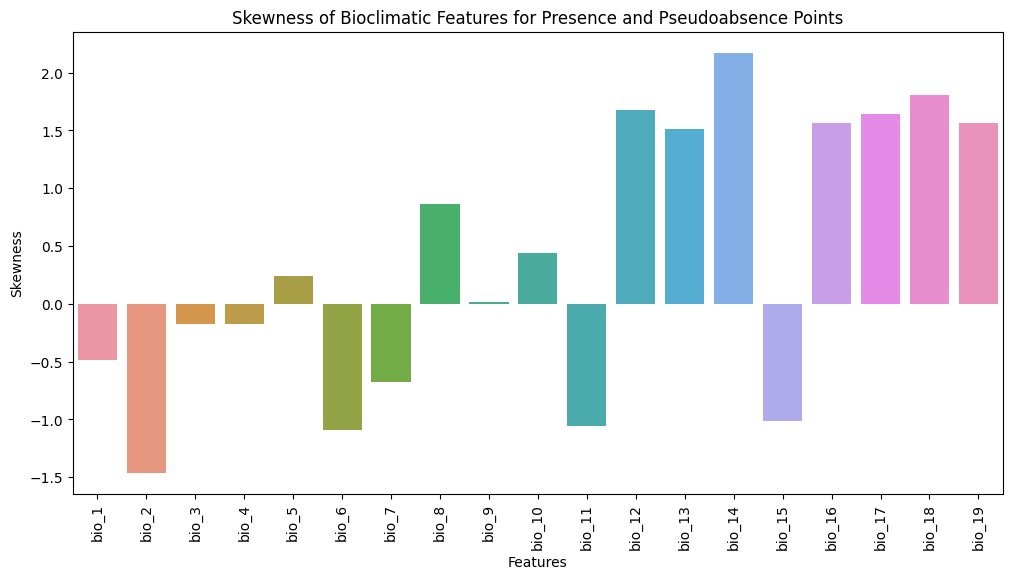

In [116]:
# Calculate skewness for each numeric feature
skewness = pre_pseu_iso.iloc[:,2:21].skew()

# Create a bar plot for skewness values
plt.figure(figsize=(12, 6))
sns.barplot(x=skewness.index, y=skewness.values)
plt.title('Skewness of Bioclimatic Features for Presence and Pseudoabsence Points')
plt.ylabel('Skewness')
plt.xlabel('Features')
plt.xticks(rotation=90)  # Rotate feature names for better readability

# Show the plot
plt.show()

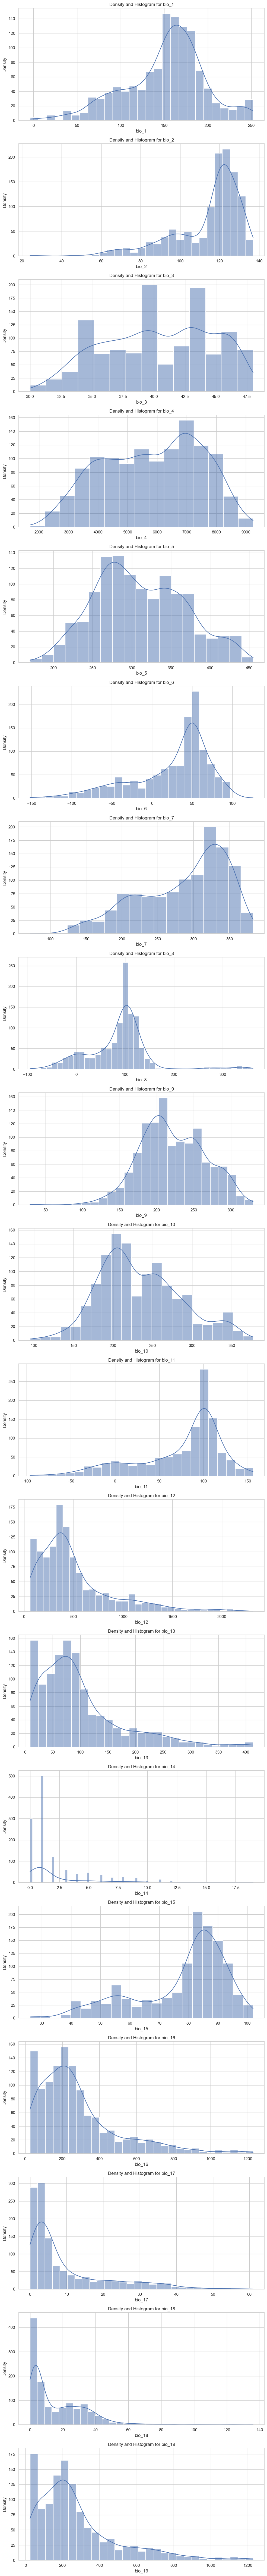

In [117]:
sns.set(style='whitegrid')

fig, axes = plt.subplots(nrows=len(pre_pseu_iso.iloc[:,2:21].columns), ncols=1, figsize=(10, 5*len(pre_pseu_iso.iloc[:,2:21].columns)))

# Looped through each column and created a density plot
for i, col in enumerate(pre_pseu_iso.iloc[:,2:21].columns):
    sns.histplot(pre_pseu_iso.iloc[:,2:21][col], ax=axes[i], kde=True)  
    axes[i].set_title(f'Density and Histogram for {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')

plt.tight_layout()  
plt.show()


***

# `Implementation`

In [118]:
pre_pseu_iso = pd.read_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Crop Suitability Modeling/Data/saved_csv/pre_pseu_iso_str.csv')

In [119]:
# Loading bioclimatic variables data
bioclim_data = []
for i in range(1, 20):
    file_name = "/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Crop Suitability Modeling/Data/bioclims/californiaclipped/bio_" + str(i) + ".tif"
    with rasterio.open(file_name) as src:
        data = src.read(1).astype(np.float32)
        # Masked out nodata values
        data = np.ma.masked_equal(data, src.nodata)
        bioclim_data.append(data)

bioclim_data = np.stack(bioclim_data, axis=2)

In [120]:
bioclim_data

masked_array(
  data=[[[-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         [-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         [-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         ...,
         [-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         [-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         [-32768.,    255.,    127., ...,  65535.,  65535.,  65535.]],

        [[-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         [-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         [-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         ...,
         [-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         [-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         [-32768.,    255.,    127., ...,  65535.,  65535.,  65535.]],

        [[-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         [-32768.,    255.,    127., ...,  6

In [121]:
# Loaded data
df_presences = pd.read_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Crop Suitability Modeling/Data/saved_csv/straw_pres_bio_df.csv')
df_pseudoabsences = pd.read_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Crop Suitability Modeling/Data/saved_csv/unsuitable_iso_scaled_str.csv')

# Assigned class labels
df_presences['presence']=1
df_pseudoabsences['presence']=0

In [122]:
df_presences.rename(columns={'SPECIES':'Species','LONGITUDE':'Longitude','LATITUDE':'Latitude'}, inplace=True)

In [123]:
df_presences

,Species,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,...,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19,presence
0,221,-121.730795,41.829775,91,119,35,7289,292,-43,335,...,0,350,49,7,45,143,30,30,136,1
1,221,-122.345282,41.689828,113,121,36,7102,309,-21,330,...,23,538,88,9,61,256,34,34,254,1
2,221,-120.429168,41.572345,95,116,33,7895,302,-48,350,...,-4,399,56,7,48,163,28,28,162,1
3,221,-121.114908,41.130171,103,120,34,7682,307,-40,347,...,5,413,62,5,55,185,20,20,185,1
4,221,-121.045248,41.139732,102,120,34,7698,307,-41,348,...,5,388,55,5,51,164,21,21,164,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,221,-118.015320,33.861685,196,106,43,4728,327,83,244,...,135,343,79,0,97,221,1,2,207,1
536,221,-118.389675,33.752512,174,90,44,3943,285,80,205,...,124,389,86,0,96,254,3,4,228,1
537,221,-118.020359,33.799740,195,103,43,4603,323,85,238,...,136,331,76,0,97,214,1,2,199,1
538,221,-117.780775,33.674746,192,101,43,4559,319,84,234,...,134,294,61,0,92,181,2,4,162,1


In [124]:
df_pseudoabsences

,Longitude,Latitude,geometry,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,...,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19,presence
0,-117.286814,36.106151,POINT (-117.28681416128616 36.10615056654887),224.0,119,32,8726.0,423.0,52.0,370.0,...,107.0,79.0,14.0,1.0,62.0,41.0,5.0,17.0,35.0,0
1,-123.715982,40.220733,POINT (-123.71598223717804 40.220733123888316),128.0,93,41,4652.0,262.0,34.0,228.0,...,69.0,1539.0,291.0,2.0,80.0,852.0,19.0,28.0,852.0,0
2,-123.482174,41.980230,POINT (-123.48217418511497 41.9802303850046),74.0,103,40,5258.0,227.0,-29.0,256.0,...,8.0,1918.0,399.0,6.0,91.0,1187.0,27.0,36.0,1187.0,0
3,-116.083303,33.020088,POINT (-116.08330328148014 33.02008845068003),218.0,135,42,6321.0,392.0,74.0,317.0,...,136.0,126.0,24.0,1.0,64.0,66.0,3.0,25.0,66.0,0
4,-123.251079,40.025317,POINT (-123.25107853264302 40.025317492696644),124.0,110,40,5617.0,286.0,10.0,275.0,...,51.0,1079.0,209.0,1.0,84.0,611.0,14.0,19.0,611.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673,-117.440188,36.404934,POINT (-117.4401879534564 36.404933555430055),211.0,117,31,8747.0,410.0,41.0,368.0,...,95.0,85.0,13.0,2.0,53.0,40.0,8.0,19.0,34.0,0
674,-124.310930,40.241995,POINT (-124.31093001306071 40.24199456384184),122.0,49,39,2665.0,194.0,68.0,125.0,...,90.0,2116.0,409.0,3.0,87.0,1203.0,19.0,36.0,1203.0,0
675,-117.122139,36.037518,POINT (-117.12213931474571 36.03751846943989),120.0,120,34,7990.0,310.0,-40.0,350.0,...,14.0,137.0,24.0,2.0,61.0,70.0,10.0,31.0,55.0,0
676,-117.813230,35.433641,POINT (-117.81322993732283 35.433640583193004),153.0,126,36,7549.0,342.0,0.0,342.0,...,55.0,142.0,28.0,1.0,75.0,82.0,4.0,16.0,68.0,0


In [125]:
df_presences.drop(columns=['Species'])

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19,presence
0,-121.730795,41.829775,91,119,35,7289,292,-43,335,10,...,0,350,49,7,45,143,30,30,136,1
1,-122.345282,41.689828,113,121,36,7102,309,-21,330,30,...,23,538,88,9,61,256,34,34,254,1
2,-120.429168,41.572345,95,116,33,7895,302,-48,350,6,...,-4,399,56,7,48,163,28,28,162,1
3,-121.114908,41.130171,103,120,34,7682,307,-40,347,5,...,5,413,62,5,55,185,20,20,185,1
4,-121.045248,41.139732,102,120,34,7698,307,-41,348,5,...,5,388,55,5,51,164,21,21,164,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,-118.015320,33.861685,196,106,43,4728,327,83,244,142,...,135,343,79,0,97,221,1,2,207,1
536,-118.389675,33.752512,174,90,44,3943,285,80,205,128,...,124,389,86,0,96,254,3,4,228,1
537,-118.020359,33.799740,195,103,43,4603,323,85,238,142,...,136,331,76,0,97,214,1,2,199,1
538,-117.780775,33.674746,192,101,43,4559,319,84,234,140,...,134,294,61,0,92,181,2,4,162,1


In [126]:
pd.concat([df_presences.drop(columns=['Species']),df_pseudoabsences.drop(columns=['geometry'])])

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19,presence
0,-121.730795,41.829775,91.0,119,35,7289.0,292.0,-43.0,335.0,10.0,...,0.0,350.0,49.0,7.0,45.0,143.0,30.0,30.0,136.0,1
1,-122.345282,41.689828,113.0,121,36,7102.0,309.0,-21.0,330.0,30.0,...,23.0,538.0,88.0,9.0,61.0,256.0,34.0,34.0,254.0,1
2,-120.429168,41.572345,95.0,116,33,7895.0,302.0,-48.0,350.0,6.0,...,-4.0,399.0,56.0,7.0,48.0,163.0,28.0,28.0,162.0,1
3,-121.114908,41.130171,103.0,120,34,7682.0,307.0,-40.0,347.0,5.0,...,5.0,413.0,62.0,5.0,55.0,185.0,20.0,20.0,185.0,1
4,-121.045248,41.139732,102.0,120,34,7698.0,307.0,-41.0,348.0,5.0,...,5.0,388.0,55.0,5.0,51.0,164.0,21.0,21.0,164.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673,-117.440188,36.404934,211.0,117,31,8747.0,410.0,41.0,368.0,109.0,...,95.0,85.0,13.0,2.0,53.0,40.0,8.0,19.0,34.0,0
674,-124.310930,40.241995,122.0,49,39,2665.0,194.0,68.0,125.0,90.0,...,90.0,2116.0,409.0,3.0,87.0,1203.0,19.0,36.0,1203.0,0
675,-117.122139,36.037518,120.0,120,34,7990.0,310.0,-40.0,350.0,27.0,...,14.0,137.0,24.0,2.0,61.0,70.0,10.0,31.0,55.0,0
676,-117.813230,35.433641,153.0,126,36,7549.0,342.0,0.0,342.0,65.0,...,55.0,142.0,28.0,1.0,75.0,82.0,4.0,16.0,68.0,0


In [127]:
def extract_windowed_data(presence_points, bioclim_data, window_size=8):
    """
    Extracts windowed bioclimatic variable data around crop presence points.
    
    Parameters:
    -----------
    presence_points : pandas.DataFrame
        A pandas dataframe containing crop presence points with 'Longitude', 'Latitude', 
        and 'presence' columns.
    bioclim_data : numpy.ndarray
        A numpy array containing bioclimatic variable data.
    window_size : int, optional
        The size of the window around the crop presence point to extract. Default is 32.
        
    Returns:
    --------
    tuple
        A tuple containing two numpy arrays. The first array contains the extracted windowed
        bioclimatic variable data, and the second array contains the corresponding crop presence
        labels.
    """
    x = []
    y = []
    window_size=int(window_size/2)

    for _, row in presence_points.iterrows():
        # Convert latitude and longitude to pixel coordinates
        lon, lat = row['Longitude'], row['Latitude']
        x_coord, y_coord = src.index(lon, lat)
        #x_coord, y_coord = int(x_coord), int(y_coord)


        # Check if window is large enough
        if x_coord >= window_size and x_coord < src.width - window_size and \
           y_coord >= window_size and y_coord < src.height - window_size:
            # Extract a window of size window_size X window_size around the crop presence point
            window = bioclim_data[y_coord-window_size:y_coord+window_size, x_coord-window_size:x_coord+window_size, :]

            # Append the window and patch area to lists
            x.append(window)
            y.append(row['presence'])

        else:
            print(f"Skipping crop presence point at ({lon}, {lat}) due to being too close to the edge.")

    # Convert to numpy arrays
    x = np.array(x)
    y = np.array(y)

    print(f"Number of crop presence points with large enough windows: {len(x)}")

    return x, y

In [128]:
x1,y1 = extract_windowed_data(df_presences, bioclim_data)

# x1,y1 = extract_windowed_data(presence_bio_df, bioclim_data)

Number of crop presence points with large enough windows: 540


In [129]:
x2,y2 = extract_windowed_data(df_pseudoabsences, bioclim_data)

# x2,y2 = extract_windowed_data(pseudoabsences_bio_df2, bioclim_data)

Skipping crop presence point at (-123.48217418511496, 41.9802303850046) due to being too close to the edge.
Skipping crop presence point at (-114.96239787869736, 34.950105288412985) due to being too close to the edge.
Skipping crop presence point at (-114.6577569178699, 34.16754598187273) due to being too close to the edge.
Skipping crop presence point at (-120.03455148722702, 41.90360298920087) due to being too close to the edge.
Skipping crop presence point at (-114.85254115196037, 33.94810688028234) due to being too close to the edge.
Skipping crop presence point at (-123.83582019446062, 41.842935028937376) due to being too close to the edge.
Skipping crop presence point at (-114.60554059458376, 34.8461824731934) due to being too close to the edge.
Skipping crop presence point at (-121.54670634218638, 41.88216728750984) due to being too close to the edge.
Skipping crop presence point at (-122.7832453535165, 41.93944753823173) due to being too close to the edge.
Skipping crop presenc

In [130]:
len(x2[0][0][1])

19

# **Model Iteration**

In [131]:
import time

start_time = time.time()

## `Data Preparation`

In [132]:
import pandas as pd

# Initialized an empty DataFrame to store model metrics
model_metrics = pd.DataFrame(columns=['Model Name', 'Epoch', 'Batch Size', 'Validation Accuracy', 'Validation Precision', 'Validation Recall', 'Validation F1 Score', 'Validation AUC', 'Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1 Score', 'Test AUC'])

# Function to append new model metrics
def append_model_metrics(metrics_df, name, epoch, batch_size,
                         accuracy_val, precision_val, recall_val, f1score_val, auc_val,
                         accuracy_test, precision_test, recall_test, f1score_test, auc_test):
    new_row = {
        'Model Name': name,
        'Epoch': epoch,
        'Batch Size': batch_size,
        'Validation Accuracy': accuracy_val,
        'Validation Precision': precision_val,
        'Validation Recall': recall_val,
        'Validation F1 Score': f1score_val,
        'Validation AUC': auc_val,
        'Test Accuracy': accuracy_test,
        'Test Precision': precision_test,
        'Test Recall': recall_test,
        'Test F1 Score': f1score_test,
        'Test AUC': auc_test
    }
    return pd.concat([metrics_df, pd.DataFrame([new_row])], ignore_index=True)

In [133]:
pre_pseu_iso

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19,presence
0,-121.730795,41.829775,91.0,119,35,7289.0,292.0,-43.0,335.0,10.0,...,0.0,350.0,49.0,7.0,45.0,143.0,30.0,30.0,136.0,1
1,-122.345282,41.689828,113.0,121,36,7102.0,309.0,-21.0,330.0,30.0,...,23.0,538.0,88.0,9.0,61.0,256.0,34.0,34.0,254.0,1
2,-120.429168,41.572345,95.0,116,33,7895.0,302.0,-48.0,350.0,6.0,...,-4.0,399.0,56.0,7.0,48.0,163.0,28.0,28.0,162.0,1
3,-121.114908,41.130171,103.0,120,34,7682.0,307.0,-40.0,347.0,5.0,...,5.0,413.0,62.0,5.0,55.0,185.0,20.0,20.0,185.0,1
4,-121.045248,41.139732,102.0,120,34,7698.0,307.0,-41.0,348.0,5.0,...,5.0,388.0,55.0,5.0,51.0,164.0,21.0,21.0,164.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1213,-117.440188,36.404934,211.0,117,31,8747.0,410.0,41.0,368.0,109.0,...,95.0,85.0,13.0,2.0,53.0,40.0,8.0,19.0,34.0,0
1214,-124.310930,40.241995,122.0,49,39,2665.0,194.0,68.0,125.0,90.0,...,90.0,2116.0,409.0,3.0,87.0,1203.0,19.0,36.0,1203.0,0
1215,-117.122139,36.037518,120.0,120,34,7990.0,310.0,-40.0,350.0,27.0,...,14.0,137.0,24.0,2.0,61.0,70.0,10.0,31.0,55.0,0
1216,-117.813230,35.433641,153.0,126,36,7549.0,342.0,0.0,342.0,65.0,...,55.0,142.0,28.0,1.0,75.0,82.0,4.0,16.0,68.0,0


In [134]:
pre_pseu_iso.iloc[:, 2:21]

,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
0,91.0,119,35,7289.0,292.0,-43.0,335.0,10.0,203.0,203.0,0.0,350.0,49.0,7.0,45.0,143.0,30.0,30.0,136.0
1,113.0,121,36,7102.0,309.0,-21.0,330.0,30.0,220.0,220.0,23.0,538.0,88.0,9.0,61.0,256.0,34.0,34.0,254.0
2,95.0,116,33,7895.0,302.0,-48.0,350.0,6.0,216.0,216.0,-4.0,399.0,56.0,7.0,48.0,163.0,28.0,28.0,162.0
3,103.0,120,34,7682.0,307.0,-40.0,347.0,5.0,219.0,219.0,5.0,413.0,62.0,5.0,55.0,185.0,20.0,20.0,185.0
4,102.0,120,34,7698.0,307.0,-41.0,348.0,5.0,219.0,219.0,5.0,388.0,55.0,5.0,51.0,164.0,21.0,21.0,164.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1213,211.0,117,31,8747.0,410.0,41.0,368.0,109.0,285.0,335.0,95.0,85.0,13.0,2.0,53.0,40.0,8.0,19.0,34.0
1214,122.0,49,39,2665.0,194.0,68.0,125.0,90.0,154.0,161.0,90.0,2116.0,409.0,3.0,87.0,1203.0,19.0,36.0,1203.0
1215,120.0,120,34,7990.0,310.0,-40.0,350.0,27.0,188.0,234.0,14.0,137.0,24.0,2.0,61.0,70.0,10.0,31.0,55.0
1216,153.0,126,36,7549.0,342.0,0.0,342.0,65.0,214.0,262.0,55.0,142.0,28.0,1.0,75.0,82.0,4.0,16.0,68.0


### `Stacked Classifier`

In [135]:
pre_pseu_iso

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19,presence
0,-121.730795,41.829775,91.0,119,35,7289.0,292.0,-43.0,335.0,10.0,...,0.0,350.0,49.0,7.0,45.0,143.0,30.0,30.0,136.0,1
1,-122.345282,41.689828,113.0,121,36,7102.0,309.0,-21.0,330.0,30.0,...,23.0,538.0,88.0,9.0,61.0,256.0,34.0,34.0,254.0,1
2,-120.429168,41.572345,95.0,116,33,7895.0,302.0,-48.0,350.0,6.0,...,-4.0,399.0,56.0,7.0,48.0,163.0,28.0,28.0,162.0,1
3,-121.114908,41.130171,103.0,120,34,7682.0,307.0,-40.0,347.0,5.0,...,5.0,413.0,62.0,5.0,55.0,185.0,20.0,20.0,185.0,1
4,-121.045248,41.139732,102.0,120,34,7698.0,307.0,-41.0,348.0,5.0,...,5.0,388.0,55.0,5.0,51.0,164.0,21.0,21.0,164.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1213,-117.440188,36.404934,211.0,117,31,8747.0,410.0,41.0,368.0,109.0,...,95.0,85.0,13.0,2.0,53.0,40.0,8.0,19.0,34.0,0
1214,-124.310930,40.241995,122.0,49,39,2665.0,194.0,68.0,125.0,90.0,...,90.0,2116.0,409.0,3.0,87.0,1203.0,19.0,36.0,1203.0,0
1215,-117.122139,36.037518,120.0,120,34,7990.0,310.0,-40.0,350.0,27.0,...,14.0,137.0,24.0,2.0,61.0,70.0,10.0,31.0,55.0,0
1216,-117.813230,35.433641,153.0,126,36,7549.0,342.0,0.0,342.0,65.0,...,55.0,142.0,28.0,1.0,75.0,82.0,4.0,16.0,68.0,0


In [136]:
# Data Preparation
X = pre_pseu_iso.iloc[:, 2:21].values  # feature columns
y = pre_pseu_iso['presence'].values  # target column

# Splitting data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # Splitting into 70% training and 30% temporary
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # Splitting temporary into 50% validation and 50% test

# Data normalization - fiting the scaler only on the training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Define the base learners
base_learners = [
    ('dt', DecisionTreeClassifier(max_depth=3)),
    ('svm', SVC(probability=True))
]

# Define the meta-learner
meta_learner = LogisticRegression()

# Create the stacking model
model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

# Training the model
model.fit(X_train, y_train)


StackingClassifier(estimators=[('dt', DecisionTreeClassifier(max_depth=3)),
                               ('svm', SVC(probability=True))],
                   final_estimator=LogisticRegression())

In [137]:

# Prediction on validation set
y_pred_val = model.predict(X_val)
y_pred_proba_val = model.predict_proba(X_val)[:, 1]

# Prediction on test set
y_pred_test = model.predict(X_test)
y_pred_proba_test = model.predict_proba(X_test)[:, 1]


In [138]:

# Evaluation on Validation Set
accuracy_val = accuracy_score(y_val, y_pred_val)
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1score_val = f1_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_proba_val)

print("Validation Accuracy :", accuracy_val)
print("Validation Precision:", precision_val)
print("Validation Recall   :", recall_val)
print("Validation F1 Score :", f1score_val)
print("Validation AUC      :", auc_val)


Validation Accuracy : 0.9617486338797814
Validation Precision: 0.9425287356321839
Validation Recall   : 0.9761904761904762
Validation F1 Score : 0.95906432748538
Validation AUC      : 0.9753487253487254


In [139]:

# Evaluation on Test Set
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1score_test = f1_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_pred_proba_test)

print("Test Accuracy       :", accuracy_test)
print("Test Precision      :", precision_test)
print("Test Recall         :", recall_test)
print("Test F1 Score       :", f1score_test)
print("Test AUC            :", auc_test)


Test Accuracy       : 0.9453551912568307
Test Precision      : 0.963855421686747
Test Recall         : 0.9195402298850575
Test F1 Score       : 0.9411764705882354
Test AUC            : 0.9673132183908046


In [140]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(852, 19) (183, 19) (183, 19)
(852,) (183,) (183,)


In [141]:
# Adding Model Metrics to Metrics Dataframe
model_metrics = append_model_metrics(
    metrics_df=model_metrics,
    name='Stacked Classifier',
    epoch=str("-"),
    batch_size=str("-"),
    accuracy_val=accuracy_val,
    precision_val=precision_val,
    recall_val=recall_val,
    f1score_val=f1score_val,
    auc_val=auc_val,
    accuracy_test=accuracy_test,
    precision_test=precision_test,
    recall_test=recall_test,
    f1score_test=f1score_test,
    auc_test=auc_test
)

In [142]:
model_metrics

,Model Name,Epoch,Batch Size,Validation Accuracy,Validation Precision,Validation Recall,Validation F1 Score,Validation AUC,Test Accuracy,Test Precision,Test Recall,Test F1 Score,Test AUC
0,Stacked Classifier,-,-,0.961749,0.942529,0.97619,0.959064,0.975349,0.945355,0.963855,0.91954,0.941176,0.967313


# `Gradient Boosting Machines (GBM)`

In [143]:
# Data Preparation
X = pre_pseu_iso.iloc[:, 2:21].values  # feature columns
y = pre_pseu_iso['presence'].values  # target column

# Splitting data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # Splitting into 70% training and 30% temporary
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # Splitting temporary into 50% validation and 50% test

# Data normalization - fiting the scaler only on the training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Initialized the Gradient Boosting
model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)

# Training the model
model.fit(X_train, y_train)


GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=42)

In [144]:

# Prediction on validation set
y_pred_val = model.predict(X_val)
y_pred_proba_val = model.predict_proba(X_val)[:, 1]

# Prediction on test set
y_pred_test = model.predict(X_test)
y_pred_proba_test = model.predict_proba(X_test)[:, 1]


In [145]:

# Evaluation on Validation Set
accuracy_val = accuracy_score(y_val, y_pred_val)
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1score_val = f1_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_proba_val)

print("Validation Accuracy :", accuracy_val)
print("Validation Precision:", precision_val)
print("Validation Recall   :", recall_val)
print("Validation F1 Score :", f1score_val)
print("Validation AUC      :", auc_val)


Validation Accuracy : 0.9562841530054644
Validation Precision: 0.9222222222222223
Validation Recall   : 0.9880952380952381
Validation F1 Score : 0.9540229885057472
Validation AUC      : 0.9636844636844638


In [146]:

# Evaluation on Test Set
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1score_test = f1_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_pred_proba_test)

print("Test Accuracy       :", accuracy_test)
print("Test Precision      :", precision_test)
print("Test Recall         :", recall_test)
print("Test F1 Score       :", f1score_test)
print("Test AUC            :", auc_test)


Test Accuracy       : 0.9344262295081968
Test Precision      : 0.9411764705882353
Test Recall         : 0.9195402298850575
Test F1 Score       : 0.9302325581395349
Test AUC            : 0.9464200191570881


In [147]:
model_metrics = append_model_metrics(
    metrics_df=model_metrics,
    name='Gradient Boosting',
    epoch=str("-"),
    batch_size=str("-"),
    accuracy_val=accuracy_val,
    precision_val=precision_val,
    recall_val=recall_val,
    f1score_val=f1score_val,
    auc_val=auc_val,
    accuracy_test=accuracy_test,
    precision_test=precision_test,
    recall_test=recall_test,
    f1score_test=f1score_test,
    auc_test=auc_test
)

# `XGBoost Classifier`

In [148]:
# Data Preparation
X = pre_pseu_iso.iloc[:, 2:21].values  # feature columns
y = pre_pseu_iso['presence'].values  # target column

# Splitting data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # Splitting into 70% training and 30% temporary
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # Splitting temporary into 50% validation and 50% test

# Data normalization - fiting the scaler only on the training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Initialized the  XGBoost
xgboost_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, use_label_encoder=False)

# Training the model
xgboost_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [149]:

# Prediction on validation set
y_pred_val = xgboost_model.predict(X_val)
y_pred_proba_val = xgboost_model.predict_proba(X_val)[:, 1]

# Prediction on test set
y_pred_test = xgboost_model.predict(X_test)
y_pred_proba_test = xgboost_model.predict_proba(X_test)[:, 1]


In [150]:

# Evaluation on Validation Set
accuracy_val = accuracy_score(y_val, y_pred_val)
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1score_val = f1_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_proba_val)

print("Validation Accuracy :", accuracy_val)
print("Validation Precision:", precision_val)
print("Validation Recall   :", recall_val)
print("Validation F1 Score :", f1score_val)
print("Validation AUC      :", auc_val)


Validation Accuracy : 0.9672131147540983
Validation Precision: 0.9431818181818182
Validation Recall   : 0.9880952380952381
Validation F1 Score : 0.9651162790697674
Validation AUC      : 0.9907407407407407


In [151]:

# Evaluation on Test Set
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1score_test = f1_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_pred_proba_test)

print("Test Accuracy       :", accuracy_test)
print("Test Precision      :", precision_test)
print("Test Recall         :", recall_test)
print("Test F1 Score       :", f1score_test)
print("Test AUC            :", auc_test)


Test Accuracy       : 0.9289617486338798
Test Precision      : 0.9625
Test Recall         : 0.8850574712643678
Test F1 Score       : 0.9221556886227545
Test AUC            : 0.9825191570881225


In [152]:
model_metrics = append_model_metrics(
    metrics_df=model_metrics,
    name='XGBoost',
    epoch=str("-"),
    batch_size=str("-"),
    accuracy_val=accuracy_val,
    precision_val=precision_val,
    recall_val=recall_val,
    f1score_val=f1score_val,
    auc_val=auc_val,
    accuracy_test=accuracy_test,
    precision_test=precision_test,
    recall_test=recall_test,
    f1score_test=f1score_test,
    auc_test=auc_test
)

# `Bagging RandomForest`

In [153]:
# Data Preparation
X = pre_pseu_iso.iloc[:, 2:21].values  # feature columns
y = pre_pseu_iso['presence'].values  # target column

# Splitting data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # Splitting into 70% training and 30% temporary
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # Splitting temporary into 50% validation and 50% test

# Data normalization - fiting the scaler only on the training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Initialized the Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
random_forest.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [154]:

# Prediction on validation set
y_pred_val = random_forest.predict(X_val)
y_pred_proba_val = random_forest.predict_proba(X_val)[:, 1]

# Predict on test set
y_pred_test = random_forest.predict(X_test)
y_pred_proba_test = random_forest.predict_proba(X_test)[:, 1]


In [155]:

# Evaluation on Validation Set
accuracy_val = accuracy_score(y_val, y_pred_val)
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1score_val = f1_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_proba_val)

print("Validation Accuracy :", accuracy_val)
print("Validation Precision:", precision_val)
print("Validation Recall   :", recall_val)
print("Validation F1 Score :", f1score_val)
print("Validation AUC      :", auc_val)


Validation Accuracy : 0.9672131147540983
Validation Precision: 0.9431818181818182
Validation Recall   : 0.9880952380952381
Validation F1 Score : 0.9651162790697674
Validation AUC      : 0.9873737373737375


In [156]:

# Evaluation on Test Set
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1score_test = f1_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_pred_proba_test)

print("Test Accuracy       :", accuracy_test)
print("Test Precision      :", precision_test)
print("Test Recall         :", recall_test)
print("Test F1 Score       :", f1score_test)
print("Test AUC            :", auc_test)


Test Accuracy       : 0.9508196721311475
Test Precision      : 0.9875
Test Recall         : 0.9080459770114943
Test F1 Score       : 0.9461077844311377
Test AUC            : 0.9817409003831417


In [157]:
model_metrics = append_model_metrics(
    metrics_df=model_metrics,
    name='Random Forest',
    epoch=str("-"),
    batch_size=str("-"),
    accuracy_val=accuracy_val,
    precision_val=precision_val,
    recall_val=recall_val,
    f1score_val=f1score_val,
    auc_val=auc_val,
    accuracy_test=accuracy_test,
    precision_test=precision_test,
    recall_test=recall_test,
    f1score_test=f1score_test,
    auc_test=auc_test
)

In [158]:
model_metrics

,Model Name,Epoch,Batch Size,Validation Accuracy,Validation Precision,Validation Recall,Validation F1 Score,Validation AUC,Test Accuracy,Test Precision,Test Recall,Test F1 Score,Test AUC
0,Stacked Classifier,-,-,0.961749,0.942529,0.976190,0.959064,0.975349,0.945355,0.963855,0.919540,0.941176,0.967313
1,Gradient Boosting,-,-,0.956284,0.922222,0.988095,0.954023,0.963684,0.934426,0.941176,0.919540,0.930233,0.946420
2,XGBoost,-,-,0.967213,0.943182,0.988095,0.965116,0.990741,0.928962,0.962500,0.885057,0.922156,0.982519
3,Random Forest,-,-,0.967213,0.943182,0.988095,0.965116,0.987374,0.950820,0.987500,0.908046,0.946108,0.981741


# `Keras Sequential`

In [159]:
# Data Preparation
X = pre_pseu_iso.iloc[:, 2:21].values  # feature columns
y = pre_pseu_iso['presence'].values  # target column

# Splitting data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # Splitting into 70% training and 30% temporary
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # Splitting temporary into 50% validation and 50% test

# Data normalization - fit the scaler only on the training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [160]:
# Build the model
model_ks = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compiled the model
model_ks.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


2024-01-10 14:55:47.457300: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-01-10 14:55:47.457388: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-01-10 14:55:47.457397: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-01-10 14:55:47.458018: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-10 14:55:47.458633: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [161]:
print(X_train.shape, X_val.shape, X_test.shape)
print('\n')
print(y_train.shape, y_val.shape, y_test.shape)

(852, 19) (183, 19) (183, 19)


(852,) (183,) (183,)


In [162]:
# Training the model using training and validation sets
history = model_ks.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/20


2024-01-10 14:55:47.986066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 1s 19ms/step - loss: 0.4961 - accuracy: 0.7969 - val_loss: 0.3795 - val_accuracy: 0.8743
Epoch 2/20
27/27 [==============================] - 0s 8ms/step - loss: 0.3785 - accuracy: 0.8662 - val_loss: 0.3273 - val_accuracy: 0.9126
Epoch 3/20
27/27 [==============================] - 0s 8ms/step - loss: 0.3458 - accuracy: 0.8756 - val_loss: 0.3036 - val_accuracy: 0.9126
Epoch 4/20
27/27 [==============================] - 0s 9ms/step - loss: 0.3171 - accuracy: 0.8850 - val_loss: 0.2871 - val_accuracy: 0.9235
Epoch 5/20
27/27 [==============================] - 0s 8ms/step - loss: 0.3206 - accuracy: 0.8932 - val_loss: 0.2704 - val_accuracy: 0.9071
Epoch 6/20
27/27 [==============================] - 0s 8ms/step - loss: 0.3141 - accuracy: 0.8920 - val_loss: 0.2637 - val_accuracy: 0.9344
Epoch 7/20
27/27 [==============================] - 0s 8ms/step - loss: 0.3205 - accuracy: 0.8908 - val_loss: 0.2791 - val_accuracy: 0.9235
Epoch 8/20
27/27 [============

In [163]:
# Evaluation the model on the test data
test_loss, test_acc = model_ks.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# Prediction on validation set
y_pred_proba_val = model_ks.predict(X_val)
y_pred_val = (y_pred_proba_val >= 0.5).astype(int)

# Prediction on test set
y_pred_proba_test = model_ks.predict(X_test)
y_pred_test = (y_pred_proba_test >= 0.5).astype(int)

# Evaluation on Validation Set
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1score_val = f1_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_proba_val)

accuracy_val = accuracy_score(y_val, y_pred_val)

print("Validation Accuracy:", accuracy_val)
print("Validation Precision:", precision_val)
print("Validation Recall   :", recall_val)
print("Validation F1 Score :", f1score_val)
print("Validation AUC      :", auc_val)

# Evaluation on Test Set
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1score_test = f1_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_pred_proba_test)

print("Test Precision      :", precision_test)
print("Test Recall         :", recall_test)
print("Test F1 Score       :", f1score_test)
print("Test AUC            :", auc_test)

accuracy_test=test_acc

6/6 [==============================] - 0s 4ms/step - loss: 0.3551 - accuracy: 0.9126
Test accuracy: 0.9125683307647705
6/6 [==============================] - 0s 1ms/step
Validation Accuracy: 0.9398907103825137
Validation Precision: 0.8924731182795699
Validation Recall   : 0.9880952380952381
Validation F1 Score : 0.9378531073446327
Validation AUC      : 0.9528619528619529
Test Precision      : 0.8817204301075269
Test Recall         : 0.9425287356321839
Test F1 Score       : 0.9111111111111111
Test AUC            : 0.9398946360153256


In [164]:
model_metrics = append_model_metrics(
    metrics_df=model_metrics,
    name='Neural Network',
    epoch=20,
    batch_size=32,
    accuracy_val=accuracy_val,
    precision_val=precision_val,
    recall_val=recall_val,
    f1score_val=f1score_val,
    auc_val=auc_val,
    accuracy_test=accuracy_test,
    precision_test=precision_test,
    recall_test=recall_test,
    f1score_test=f1score_test,
    auc_test=auc_test
)

# Multi Layer Perceptron

In [165]:
model_enhanced_mlp = Sequential()
model_enhanced_mlp.add(Dense(128, input_shape=(X_train.shape[1],)))
model_enhanced_mlp.add(BatchNormalization())
model_enhanced_mlp.add(Activation('relu'))
model_enhanced_mlp.add(Dropout(0.5))
model_enhanced_mlp.add(Dense(64))
model_enhanced_mlp.add(BatchNormalization())
model_enhanced_mlp.add(Activation('relu'))
model_enhanced_mlp.add(Dropout(0.5))
model_enhanced_mlp.add(Dense(1, activation='sigmoid'))

model_enhanced_mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [166]:
# Trained the model using training and validation sets
history = model_enhanced_mlp.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/20


27/27 [==============================] - 1s 32ms/step - loss: 0.4584 - accuracy: 0.8192 - val_loss: 0.4044 - val_accuracy: 0.9399
Epoch 2/20
27/27 [==============================] - 0s 14ms/step - loss: 0.2637 - accuracy: 0.9120 - val_loss: 0.3249 - val_accuracy: 0.9290
Epoch 3/20
27/27 [==============================] - 0s 13ms/step - loss: 0.2435 - accuracy: 0.9131 - val_loss: 0.2978 - val_accuracy: 0.9180
Epoch 4/20
27/27 [==============================] - 0s 14ms/step - loss: 0.2056 - accuracy: 0.9237 - val_loss: 0.2785 - val_accuracy: 0.9290
Epoch 5/20
27/27 [==============================] - 0s 12ms/step - loss: 0.2036 - accuracy: 0.9308 - val_loss: 0.2610 - val_accuracy: 0.9180
Epoch 6/20
27/27 [==============================] - 0s 13ms/step - loss: 0.1934 - accuracy: 0.9401 - val_loss: 0.2503 - val_accuracy: 0.9126
Epoch 7/20
27/27 [==============================] - 0s 13ms/step - loss: 0.1886 - accuracy: 0.9366 - val_loss: 0.2532 - val_accuracy: 0.9071
Epoch 8/20
27/27 [======

In [167]:

# Evaluate the model on the test data
test_loss, test_acc = model_enhanced_mlp.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# Predict on validation set
y_pred_proba_val = model_enhanced_mlp.predict(X_val)
y_pred_val = (y_pred_proba_val >= 0.5).astype(int)

# Predict on test set
y_pred_proba_test = model_enhanced_mlp.predict(X_test)
y_pred_test = (y_pred_proba_test >= 0.5).astype(int)

# Evaluation on Validation Set
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1score_val = f1_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_proba_val)

accuracy_val = accuracy_score(y_val, y_pred_val)

print("Validation Accuracy:", accuracy_val)
print("Validation Precision:", precision_val)
print("Validation Recall   :", recall_val)
print("Validation F1 Score :", f1score_val)
print("Validation AUC      :", auc_val)

# Evaluation on Test Set
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1score_test = f1_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_pred_proba_test)

print("Test Precision      :", precision_test)
print("Test Recall         :", recall_test)
print("Test F1 Score       :", f1score_test)
print("Test AUC            :", auc_test)

accuracy_test=test_acc

6/6 [==============================] - 0s 5ms/step - loss: 0.2146 - accuracy: 0.9344
Test accuracy: 0.9344262480735779
6/6 [==============================] - 0s 2ms/step
Validation Accuracy: 0.9289617486338798
Validation Precision: 0.8736842105263158
Validation Recall   : 0.9880952380952381
Validation F1 Score : 0.9273743016759777
Validation AUC      : 0.9820827320827321
Test Precision      : 0.9310344827586207
Test Recall         : 0.9310344827586207
Test F1 Score       : 0.9310344827586207
Test AUC            : 0.9675526819923371


In [168]:
model_metrics = append_model_metrics(
    metrics_df=model_metrics,
    name='Multi Layer Perceptron',
    epoch=20,
    batch_size=32,
    accuracy_val=accuracy_val,
    precision_val=precision_val,
    recall_val=recall_val,
    f1score_val=f1score_val,
    auc_val=auc_val,
    accuracy_test=accuracy_test,
    precision_test=precision_test,
    recall_test=recall_test,
    f1score_test=f1score_test,
    auc_test=auc_test
)

# Autoencoder

In [169]:
# Defined encoder
input_data = Input(shape=(X_train.shape[1],))
encoded = Dense(64, activation='relu')(input_data)
encoded = Dense(32, activation='relu')(encoded)

# Defined decoder
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(X_train.shape[1], activation='sigmoid')(decoded)

# Autoencoder - Model
autoencoder = Model(input_data, decoded)

# Encoder - for dimensionality reduction
encoder = Model(input_data, encoded)

# Compile autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Using the encoded layer's output as features for classification
encoded_input = Input(shape=(X_train.shape[1],))
classifier_layer = Dense(1, activation='sigmoid')(encoded_input)
classifier = Model(encoded_input, classifier_layer)

# Then, compiled and trained the classifier model normally using the encoded inputs
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [170]:
# Trained the model using training and validation sets
history = classifier.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/20
27/27 [==============================] - 1s 14ms/step - loss: 0.7452 - accuracy: 0.4859 - val_loss: 0.6903 - val_accuracy: 0.5792
Epoch 2/20
27/27 [==============================] - 0s 7ms/step - loss: 0.6864 - accuracy: 0.5704 - val_loss: 0.6446 - val_accuracy: 0.6393
Epoch 3/20
27/27 [==============================] - 0s 6ms/step - loss: 0.6356 - accuracy: 0.6432 - val_loss: 0.6081 - val_accuracy: 0.6831
Epoch 4/20
27/27 [==============================] - 0s 6ms/step - loss: 0.5949 - accuracy: 0.6878 - val_loss: 0.5765 - val_accuracy: 0.6995
Epoch 5/20
27/27 [==============================] - 0s 6ms/step - loss: 0.5601 - accuracy: 0.7289 - val_loss: 0.5486 - val_accuracy: 0.7322
Epoch 6/20
27/27 [==============================] - 0s 6ms/step - loss: 0.5311 - accuracy: 0.7711 - val_loss: 0.5266 - val_accuracy: 0.7486
Epoch 7/20
27/27 [==============================] - 0s 6ms/step - loss: 0.5062 - accuracy: 0.7981 - val_loss: 0.5056 - val_accuracy: 0.7869
Epoch 8/20
27/27 [=

In [171]:

# Evaluate the model on the test data
test_loss, test_acc = classifier.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# Predict on validation set
y_pred_proba_val = classifier.predict(X_val)
y_pred_val = (y_pred_proba_val >= 0.5).astype(int)

# Predict on test set
y_pred_proba_test = classifier.predict(X_test)
y_pred_test = (y_pred_proba_test >= 0.5).astype(int)

# Evaluation on Validation Set
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1score_val = f1_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_proba_val)

accuracy_val = accuracy_score(y_val, y_pred_val)

print("Validation Accuracy:", accuracy_val)
print("Validation Precision:", precision_val)
print("Validation Recall   :", recall_val)
print("Validation F1 Score :", f1score_val)
print("Validation AUC      :", auc_val)

# Evaluation on Test Set
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1score_test = f1_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_pred_proba_test)

print("Test Precision      :", precision_test)
print("Test Recall         :", recall_test)
print("Test F1 Score       :", f1score_test)
print("Test AUC            :", auc_test)

accuracy_test=test_acc

6/6 [==============================] - 0s 4ms/step - loss: 0.4320 - accuracy: 0.8470
Test accuracy: 0.8469945192337036
6/6 [==============================] - 0s 1ms/step
Validation Accuracy: 0.9016393442622951
Validation Precision: 0.84375
Validation Recall   : 0.9642857142857143
Validation F1 Score : 0.8999999999999999
Validation AUC      : 0.9277296777296777
Test Precision      : 0.7920792079207921
Test Recall         : 0.9195402298850575
Test F1 Score       : 0.851063829787234
Test AUC            : 0.8924808429118775


In [172]:
model_metrics = append_model_metrics(
    metrics_df=model_metrics,
    name='Autoencoder',
    epoch=20,
    batch_size=32,
    accuracy_val=accuracy_val,
    precision_val=precision_val,
    recall_val=recall_val,
    f1score_val=f1score_val,
    auc_val=auc_val,
    accuracy_test=accuracy_test,
    precision_test=precision_test,
    recall_test=recall_test,
    f1score_test=f1score_test,
    auc_test=auc_test
)

## **Normalize & Split Preventing Leakage**

In [173]:
from skimage.transform import resize

# Split data into training and other sets first
X = np.vstack((x1, x2))
y = np.concatenate((y1, y2))

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalized the training set. Fiting the scaler on X_train only
scaler = StandardScaler()
X_train_reshaped = X_train.reshape(-1, 19) 
scaler.fit(X_train_reshaped)

# Transformed the training data
X_train_scaled = scaler.transform(X_train_reshaped)
X_train_scaled = X_train_scaled.reshape(X_train.shape)

# Transformed the validation and test sets based on the scaler fitted on the training data
X_val_reshaped = X_val.reshape(-1, 19)
X_val_scaled = scaler.transform(X_val_reshaped)
X_val_scaled = X_val_scaled.reshape(X_val.shape)

X_test_reshaped = X_test.reshape(-1, 19)
X_test_scaled = scaler.transform(X_test_reshaped)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

# Resized the images after scaling, if needed
X_train_resized = resize(X_train_scaled, (X_train_scaled.shape[0], 32, 32, 19))
X_val_resized = resize(X_val_scaled, (X_val_scaled.shape[0], 32, 32, 19))
X_test_resized = resize(X_test_scaled, (X_test_scaled.shape[0], 32, 32, 19))

print(X_train_resized.shape, X_val_resized.shape, X_test_resized.shape)
print(y_train.shape, y_val.shape, y_test.shape)


(805, 32, 32, 19) (172, 32, 32, 19) (173, 32, 32, 19)
(805,) (172,) (173,)


In [174]:
X_train = X_train_resized
X_val = X_val_resized
X_test = X_test_resized

#### `LeNet-5 inspired model`

In [175]:
model_lenet = Sequential()
model_lenet.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(32, 32, 19)))
model_lenet.add(MaxPooling2D(pool_size=(2, 2)))
model_lenet.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
model_lenet.add(MaxPooling2D(pool_size=(2, 2)))
model_lenet.add(Flatten())
model_lenet.add(Dense(120, activation='relu'))
model_lenet.add(Dense(84, activation='relu'))
model_lenet.add(Dense(1, activation='sigmoid'))

model_lenet.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lenet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         2856      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 6)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 16)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense_11 (Dense)            (None, 120)              

In [176]:
history=model_lenet.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
26/26 [==============================] - 2s 50ms/step - loss: 0.6463 - accuracy: 0.6696 - val_loss: 0.6082 - val_accuracy: 0.6744
Epoch 2/20
26/26 [==============================] - 0s 13ms/step - loss: 0.6264 - accuracy: 0.6832 - val_loss: 0.6723 - val_accuracy: 0.5058
Epoch 3/20
26/26 [==============================] - 0s 16ms/step - loss: 0.6293 - accuracy: 0.6671 - val_loss: 0.6052 - val_accuracy: 0.6686
Epoch 4/20
26/26 [==============================] - 0s 12ms/step - loss: 0.6321 - accuracy: 0.6571 - val_loss: 0.6527 - val_accuracy: 0.6802
Epoch 5/20
26/26 [==============================] - 0s 13ms/step - loss: 0.6306 - accuracy: 0.6932 - val_loss: 0.6007 - val_accuracy: 0.6686
Epoch 6/20
26/26 [==============================] - 0s 13ms/step - loss: 0.6126 - accuracy: 0.6907 - val_loss: 0.5951 - val_accuracy: 0.6744
Epoch 7/20
26/26 [==============================] - 0s 12ms/step - loss: 0.5908 - accuracy: 0.6907 - val_loss: 0.5858 - val_accuracy: 0.6802
Epoch 8/20
26

In [177]:
# Evaluating the model_lenet on the test data
test_loss, test_acc = model_lenet.evaluate(X_test, y_test)

# Prediction on validation set
y_pred_proba_val = model_lenet.predict(X_val)
y_pred_val = (y_pred_proba_val >= 0.5).astype(int)

# Prediction on test set
y_pred_proba_test = model_lenet.predict(X_test)
y_pred_test = (y_pred_proba_test >= 0.5).astype(int)

# Evaluation on Validation Set
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1score_val = f1_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_proba_val)
accuracy_val = accuracy_score(y_val, y_pred_val)

print("Validation Accuracy :", accuracy_val)
print("Validation Precision:", precision_val)
print("Validation Recall   :", recall_val)
print("Validation F1 Score :", f1score_val)
print("Validation AUC      :", auc_val)

# Evaluation on Test Set
accuracy_test=test_acc
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1score_test = f1_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_pred_proba_test)

print('Test accuracy       :', accuracy_test)
print("Test Precision      :", precision_test)
print("Test Recall         :", recall_test)
print("Test F1 Score       :", f1score_test)
print("Test AUC            :", auc_test)

6/6 [==============================] - 0s 6ms/step
Validation Accuracy : 0.6744186046511628
Validation Precision: 0.7843137254901961
Validation Recall   : 0.47058823529411764
Validation F1 Score : 0.5882352941176471
Validation AUC      : 0.7016903313049359
Test accuracy       : 0.6994219422340393
Test Precision      : 0.7916666666666666
Test Recall         : 0.475
Test F1 Score       : 0.5937499999999999
Test AUC            : 0.6910618279569892


In [178]:
model_metrics = append_model_metrics(
    metrics_df=model_metrics,
    name='LeNet',
    epoch=20,
    batch_size=32,
    accuracy_val=accuracy_val,
    precision_val=precision_val,
    recall_val=recall_val,
    f1score_val=f1score_val,
    auc_val=auc_val,
    accuracy_test=accuracy_test,
    precision_test=precision_test,
    recall_test=recall_test,
    f1score_test=f1score_test,
    auc_test=auc_test
)

In [179]:
model_metrics

,Model Name,Epoch,Batch Size,Validation Accuracy,Validation Precision,Validation Recall,Validation F1 Score,Validation AUC,Test Accuracy,Test Precision,Test Recall,Test F1 Score,Test AUC
0,Stacked Classifier,-,-,0.961749,0.942529,0.976190,0.959064,0.975349,0.945355,0.963855,0.919540,0.941176,0.967313
1,Gradient Boosting,-,-,0.956284,0.922222,0.988095,0.954023,0.963684,0.934426,0.941176,0.919540,0.930233,0.946420
2,XGBoost,-,-,0.967213,0.943182,0.988095,0.965116,0.990741,0.928962,0.962500,0.885057,0.922156,0.982519
3,Random Forest,-,-,0.967213,0.943182,0.988095,0.965116,0.987374,0.950820,0.987500,0.908046,0.946108,0.981741
4,Neural Network,20,32,0.939891,0.892473,0.988095,0.937853,0.952862,0.912568,0.881720,0.942529,0.911111,0.939895
5,Multi Layer Perceptron,20,32,0.928962,0.873684,0.988095,0.927374,0.982083,0.934426,0.931034,0.931034,0.931034,0.967553
6,Autoencoder,20,32,0.901639,0.843750,0.964286,0.900000,0.927730,0.846995,0.792079,0.919540,0.851064,0.892481
7,LeNet,20,32,0.674419,0.784314,0.470588,0.588235,0.701690,0.699422,0.791667,0.475000,0.593750,0.691062


#### `VGG inspired model`

In [180]:
model_vgg = Sequential()

# Block 1
model_vgg.add(Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 19), padding='same'))
model_vgg.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model_vgg.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model_vgg.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model_vgg.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model_vgg.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model_vgg.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model_vgg.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model_vgg.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model_vgg.add(MaxPooling2D(pool_size=(2, 2)))

# Classification block
model_vgg.add(Flatten())
model_vgg.add(Dense(256, activation='relu'))
model_vgg.add(Dropout(0.5))
model_vgg.add(Dense(128, activation='relu'))
model_vgg.add(Dropout(0.5))
model_vgg.add(Dense(1, activation='sigmoid'))

model_vgg.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_vgg.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        11008     
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 8, 8, 128)         0         
 g2D)                                                 

In [181]:
history=model_vgg.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
26/26 [==============================] - 2s 61ms/step - loss: 0.7138 - accuracy: 0.5938 - val_loss: 0.6445 - val_accuracy: 0.6453
Epoch 2/20
26/26 [==============================] - 1s 29ms/step - loss: 0.6586 - accuracy: 0.6621 - val_loss: 0.6434 - val_accuracy: 0.6744
Epoch 3/20
26/26 [==============================] - 1s 27ms/step - loss: 0.6874 - accuracy: 0.6658 - val_loss: 0.6408 - val_accuracy: 0.6628
Epoch 4/20
26/26 [==============================] - 1s 28ms/step - loss: 0.6674 - accuracy: 0.6261 - val_loss: 0.6521 - val_accuracy: 0.6686
Epoch 5/20
26/26 [==============================] - 1s 28ms/step - loss: 0.6917 - accuracy: 0.6634 - val_loss: 0.7086 - val_accuracy: 0.6279
Epoch 6/20
26/26 [==============================] - 1s 27ms/step - loss: 0.7418 - accuracy: 0.6596 - val_loss: 0.6271 - val_accuracy: 0.6686
Epoch 7/20
26/26 [==============================] - 1s 27ms/step - loss: 0.6411 - accuracy: 0.6820 - val_loss: 0.6261 - val_accuracy: 0.6628
Epoch 8/20
26

In [182]:

# Evaluation the model_vgg on the test data
test_loss, test_acc = model_vgg.evaluate(X_test, y_test)

# Prediction on validation set
y_pred_proba_val = model_vgg.predict(X_val)
y_pred_val = (y_pred_proba_val >= 0.5).astype(int)

# Prediction on test set
y_pred_proba_test = model_vgg.predict(X_test)
y_pred_test = (y_pred_proba_test >= 0.5).astype(int)

# Evaluation on Validation Set
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1score_val = f1_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_proba_val)
accuracy_val = accuracy_score(y_val, y_pred_val)

print("Validation Accuracy :", accuracy_val)
print("Validation Precision:", precision_val)
print("Validation Recall   :", recall_val)
print("Validation F1 Score :", f1score_val)
print("Validation AUC      :", auc_val)

# Evaluation on Test Set
accuracy_test=test_acc
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1score_test = f1_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_pred_proba_test)

print('Test accuracy       :', accuracy_test)
print("Test Precision      :", precision_test)
print("Test Recall         :", recall_test)
print("Test F1 Score       :", f1score_test)
print("Test AUC            :", auc_test)



model_metrics = append_model_metrics(
    metrics_df=model_metrics,
    name='VGG',
    epoch=20,
    batch_size=32,
    accuracy_val=accuracy_val,
    precision_val=precision_val,
    recall_val=recall_val,
    f1score_val=f1score_val,
    auc_val=auc_val,
    accuracy_test=accuracy_test,
    precision_test=precision_test,
    recall_test=recall_test,
    f1score_test=f1score_test,
    auc_test=auc_test
)

6/6 [==============================] - 0s 16ms/step
Validation Accuracy : 0.6802325581395349
Validation Precision: 0.8
Validation Recall   : 0.47058823529411764
Validation F1 Score : 0.5925925925925927
Validation AUC      : 0.7665314401622718
Test accuracy       : 0.6994219422340393
Test Precision      : 0.7692307692307693
Test Recall         : 0.5
Test F1 Score       : 0.6060606060606061
Test AUC            : 0.7455645161290323


### `ResNet50 Architechture`

In [183]:
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model
from keras.initializers import glorot_uniform

def identity_block(X, f, filters, stage, block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters
    X_shortcut = X

    # First component of main path
    X = Conv2D(F1, (1, 1), strides=(1, 1), padding='same', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(F2, (f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(F3, (1, 1), strides=(1, 1), padding='same', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    # Shortcut path
    X_shortcut = Conv2D(F3, (1, 1), strides=(1, 1), padding='same', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    # Final step: Added the shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


def ResNet50(input_shape=(32, 32, 19)):
    # Define the input
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='a')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    # Output layer
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc' + str(1), kernel_initializer=glorot_uniform(seed=0))(X)

    # Create Final Model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

model_resnet50 = ResNet50(input_shape=(32, 32, 19))
model_resnet50.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_resnet50.summary()


Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 32, 19)]         0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 38, 38, 19)           0         ['input_3[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1 (Conv2D)              (None, 16, 16, 64)           59648     ['zero_padding2d[0][0]']      
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1[0][0]']        

In [184]:
history=model_resnet50.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
26/26 [==============================] - 3s 86ms/step - loss: 0.8506 - accuracy: 0.6199 - val_loss: 1.1485 - val_accuracy: 0.4942
Epoch 2/20
26/26 [==============================] - 1s 29ms/step - loss: 0.6493 - accuracy: 0.6981 - val_loss: 0.8440 - val_accuracy: 0.6453
Epoch 3/20
26/26 [==============================] - 1s 31ms/step - loss: 0.6751 - accuracy: 0.7180 - val_loss: 0.6606 - val_accuracy: 0.6570
Epoch 4/20
26/26 [==============================] - 1s 30ms/step - loss: 0.6670 - accuracy: 0.6658 - val_loss: 0.8144 - val_accuracy: 0.6686
Epoch 5/20
26/26 [==============================] - 1s 30ms/step - loss: 0.5504 - accuracy: 0.7366 - val_loss: 0.8355 - val_accuracy: 0.5174
Epoch 6/20
26/26 [==============================] - 1s 30ms/step - loss: 0.5402 - accuracy: 0.7143 - val_loss: 1.3980 - val_accuracy: 0.5058
Epoch 7/20
26/26 [==============================] - 1s 29ms/step - loss: 0.4633 - accuracy: 0.7950 - val_loss: 2.0537 - val_accuracy: 0.5058
Epoch 8/20
26

In [185]:

# Evaluation the model on the test data
test_loss, test_acc = model_resnet50.evaluate(X_test, y_test)

# Prediction on validation set
y_pred_proba_val = model_resnet50.predict(X_val)
y_pred_val = (y_pred_proba_val >= 0.5).astype(int)

# Prediction on test set
y_pred_proba_test = model_resnet50.predict(X_test)
y_pred_test = (y_pred_proba_test >= 0.5).astype(int)

# Evaluation on Validation Set
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1score_val = f1_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_proba_val)
accuracy_val = accuracy_score(y_val, y_pred_val)

print("Validation Accuracy :", accuracy_val)
print("Validation Precision:", precision_val)
print("Validation Recall   :", recall_val)
print("Validation F1 Score :", f1score_val)
print("Validation AUC      :", auc_val)

# Evaluation on Test Set
accuracy_test=test_acc
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1score_test = f1_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_pred_proba_test)

print('Test accuracy       :', accuracy_test)
print("Test Precision      :", precision_test)
print("Test Recall         :", recall_test)
print("Test F1 Score       :", f1score_test)
print("Test AUC            :", auc_test)



model_metrics = append_model_metrics(
    metrics_df=model_metrics,
    name='ResNet',
    epoch=20,
    batch_size=32,
    accuracy_val=accuracy_val,
    precision_val=precision_val,
    recall_val=recall_val,
    f1score_val=f1score_val,
    auc_val=auc_val,
    accuracy_test=accuracy_test,
    precision_test=precision_test,
    recall_test=recall_test,
    f1score_test=f1score_test,
    auc_test=auc_test
)

6/6 [==============================] - 0s 24ms/step
Validation Accuracy : 0.7558139534883721
Validation Precision: 0.6837606837606838
Validation Recall   : 0.9411764705882353
Validation F1 Score : 0.7920792079207921
Validation AUC      : 0.8581473968897904
Test accuracy       : 0.7687861323356628
Test Precision      : 0.6785714285714286
Test Recall         : 0.95
Test F1 Score       : 0.7916666666666667
Test AUC            : 0.8641129032258064


### `Inception Inspired Model`

In [186]:
from keras.layers import concatenate

def inception_block(X, filters):
    # 1x1 conv
    conv1 = Conv2D(filters=filters, kernel_size=(1, 1), padding='same', activation='relu')(X)

    # 3x3 conv
    conv3 = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation='relu')(X)

    # 5x5 conv
    conv5 = Conv2D(filters=filters, kernel_size=(5, 5), padding='same', activation='relu')(X)

    # 3x3 max pooling
    pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(X)

    # concatenate filters, assumes filters/channels last
    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)

    return layer_out

def InceptionNet(input_shape):
    X_input = Input(input_shape)
    
    # Inception blocks
    X = inception_block(X_input, 32)
    X = inception_block(X, 64)
    X = MaxPooling2D(pool_size=(4, 4))(X)
    
    # Flatten and fully connected layer
    X = Flatten()(X)
    X = Dense(120, activation='relu')(X)
    X = Dense(84, activation='relu')(X)
    X = Dense(1, activation='sigmoid')(X)

    # Created model
    model = Model(inputs=X_input, outputs=X, name='InceptionNet')
    
    return model

model_inception = InceptionNet(input_shape=(32, 32, 19))
model_inception.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_inception.summary()


Model: "InceptionNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 32, 32, 19)]         0         []                            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 32, 32, 32)           640       ['input_4[0][0]']             
                                                                                                  
 conv2d_10 (Conv2D)          (None, 32, 32, 32)           5504      ['input_4[0][0]']             
                                                                                                  
 conv2d_11 (Conv2D)          (None, 32, 32, 32)           15232     ['input_4[0][0]']             
                                                                                       

In [187]:
history=model_inception.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
26/26 [==============================] - 3s 84ms/step - loss: 6.3948 - accuracy: 0.5466 - val_loss: 2.8768 - val_accuracy: 0.5058
Epoch 2/20
26/26 [==============================] - 2s 62ms/step - loss: 1.1548 - accuracy: 0.6025 - val_loss: 1.0841 - val_accuracy: 0.5174
Epoch 3/20
26/26 [==============================] - 2s 59ms/step - loss: 0.6974 - accuracy: 0.6509 - val_loss: 0.7094 - val_accuracy: 0.6744
Epoch 4/20
26/26 [==============================] - 2s 60ms/step - loss: 0.7431 - accuracy: 0.6335 - val_loss: 0.8021 - val_accuracy: 0.6744
Epoch 5/20
26/26 [==============================] - 2s 59ms/step - loss: 0.6770 - accuracy: 0.6596 - val_loss: 0.9880 - val_accuracy: 0.6686
Epoch 6/20
26/26 [==============================] - 2s 59ms/step - loss: 0.9666 - accuracy: 0.6211 - val_loss: 0.7947 - val_accuracy: 0.5581
Epoch 7/20
26/26 [==============================] - 2s 59ms/step - loss: 0.7797 - accuracy: 0.6683 - val_loss: 0.6808 - val_accuracy: 0.6977
Epoch 8/20
26

In [188]:

# Evaluated the model on the test data
test_loss, test_acc = model_inception.evaluate(X_test, y_test)

# Prediction on validation set
y_pred_proba_val = model_inception.predict(X_val)
y_pred_val = (y_pred_proba_val >= 0.5).astype(int)

# Prediction on test set
y_pred_proba_test = model_inception.predict(X_test)
y_pred_test = (y_pred_proba_test >= 0.5).astype(int)

# Evaluation on Validation Set
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1score_val = f1_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_proba_val)
accuracy_val = accuracy_score(y_val, y_pred_val)

print("Validation Accuracy :", accuracy_val)
print("Validation Precision:", precision_val)
print("Validation Recall   :", recall_val)
print("Validation F1 Score :", f1score_val)
print("Validation AUC      :", auc_val)

# Evaluation on Test Set
accuracy_test=test_acc
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1score_test = f1_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_pred_proba_test)

print('Test accuracy       :', accuracy_test)
print("Test Precision      :", precision_test)
print("Test Recall         :", recall_test)
print("Test F1 Score       :", f1score_test)
print("Test AUC            :", auc_test)



model_metrics = append_model_metrics(
    metrics_df=model_metrics,
    name='Inception',
    epoch=20,
    batch_size=32,
    accuracy_val=accuracy_val,
    precision_val=precision_val,
    recall_val=recall_val,
    f1score_val=f1score_val,
    auc_val=auc_val,
    accuracy_test=accuracy_test,
    precision_test=precision_test,
    recall_test=recall_test,
    f1score_test=f1score_test,
    auc_test=auc_test
)

6/6 [==============================] - 0s 28ms/step
Validation Accuracy : 0.5116279069767442
Validation Precision: 0.6
Validation Recall   : 0.03529411764705882
Validation F1 Score : 0.06666666666666667
Validation AUC      : 0.44631507775524004
Test accuracy       : 0.5780346989631653
Test Precision      : 0.8888888888888888
Test Recall         : 0.1
Test F1 Score       : 0.17977528089887643
Test AUC            : 0.45443548387096777


### `Alexnet Insipired Model`

In [189]:
model_alexnet = Sequential()

input_shape = (32, 32, 19)

# Block 1
model_alexnet.add(Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=input_shape, padding='same'))
model_alexnet.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Block 2
model_alexnet.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu', padding='same'))
model_alexnet.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Block 3
model_alexnet.add(Conv2D(filters=384, kernel_size=(3, 3), activation='relu', padding='same'))
model_alexnet.add(Conv2D(filters=384, kernel_size=(3, 3), activation='relu', padding='same'))
model_alexnet.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))

# Classification block
model_alexnet.add(Flatten())
model_alexnet.add(Dense(4096, activation='relu'))
model_alexnet.add(Dropout(0.5))
model_alexnet.add(Dense(4096, activation='relu'))
model_alexnet.add(Dropout(0.5))
model_alexnet.add(Dense(1, activation='sigmoid'))

model_alexnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_alexnet.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 8, 8, 96)          220800    
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 4, 4, 96)          0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 4, 4, 256)         614656    
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 2, 2, 256)         0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 2, 2, 384)         885120    
                                                                 
 conv2d_18 (Conv2D)          (None, 2, 2, 384)        

In [190]:
history=model_alexnet.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
26/26 [==============================] - 2s 62ms/step - loss: 0.9013 - accuracy: 0.5640 - val_loss: 0.7144 - val_accuracy: 0.5058
Epoch 2/20
26/26 [==============================] - 1s 33ms/step - loss: 0.6829 - accuracy: 0.6186 - val_loss: 0.7119 - val_accuracy: 0.6686
Epoch 3/20
26/26 [==============================] - 1s 34ms/step - loss: 0.7441 - accuracy: 0.5503 - val_loss: 0.6364 - val_accuracy: 0.6686
Epoch 4/20
26/26 [==============================] - 1s 33ms/step - loss: 0.7192 - accuracy: 0.5714 - val_loss: 0.7017 - val_accuracy: 0.6686
Epoch 5/20
26/26 [==============================] - 1s 32ms/step - loss: 0.6925 - accuracy: 0.6161 - val_loss: 0.6533 - val_accuracy: 0.6570
Epoch 6/20
26/26 [==============================] - 1s 32ms/step - loss: 0.6939 - accuracy: 0.6099 - val_loss: 0.7086 - val_accuracy: 0.6686
Epoch 7/20
26/26 [==============================] - 1s 33ms/step - loss: 0.8192 - accuracy: 0.5516 - val_loss: 0.7012 - val_accuracy: 0.6744
Epoch 8/20
26

In [191]:

# Evaluate the model on the test data
test_loss, test_acc = model_alexnet.evaluate(X_test, y_test)

# Prediction on validation set
y_pred_proba_val = model_alexnet.predict(X_val)
y_pred_val = (y_pred_proba_val >= 0.5).astype(int)

# Prediction on test set
y_pred_proba_test = model_alexnet.predict(X_test)
y_pred_test = (y_pred_proba_test >= 0.5).astype(int)

# Evaluation on Validation Set
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1score_val = f1_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_proba_val)
accuracy_val = accuracy_score(y_val, y_pred_val)

print("Validation Accuracy :", accuracy_val)
print("Validation Precision:", precision_val)
print("Validation Recall   :", recall_val)
print("Validation F1 Score :", f1score_val)
print("Validation AUC      :", auc_val)

# Evaluation on Test Set
accuracy_test=test_acc
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1score_test = f1_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_pred_proba_test)

print('Test accuracy       :', accuracy_test)
print("Test Precision      :", precision_test)
print("Test Recall         :", recall_test)
print("Test F1 Score       :", f1score_test)
print("Test AUC            :", auc_test)



model_metrics = append_model_metrics(
    metrics_df=model_metrics,
    name='AlexNet',
    epoch=20,
    batch_size=32,
    accuracy_val=accuracy_val,
    precision_val=precision_val,
    recall_val=recall_val,
    f1score_val=f1score_val,
    auc_val=auc_val,
    accuracy_test=accuracy_test,
    precision_test=precision_test,
    recall_test=recall_test,
    f1score_test=f1score_test,
    auc_test=auc_test
)

6/6 [==============================] - 0s 12ms/step
Validation Accuracy : 0.4941860465116279
Validation Precision: 0.4941860465116279
Validation Recall   : 1.0
Validation F1 Score : 0.6614785992217899
Validation AUC      : 0.5
Test accuracy       : 0.4624277353286743
Test Precision      : 0.4624277456647399
Test Recall         : 1.0
Test F1 Score       : 0.6324110671936759
Test AUC            : 0.5


### `Mobilenet Inspired Model`

In [192]:
model_mobilenet = Sequential()

# Depthwise Separable Convolution Block 1
model_mobilenet.add(DepthwiseConv2D(kernel_size=(3, 3), input_shape=(32, 32, 19), activation='relu', padding='same'))
model_mobilenet.add(Conv2D(64, (1, 1), activation='relu', padding='same'))
model_mobilenet.add(MaxPooling2D(pool_size=(2, 2)))

# Depthwise Separable Convolution Block 2
model_mobilenet.add(DepthwiseConv2D(kernel_size=(3, 3), activation='relu', padding='same'))
model_mobilenet.add(Conv2D(128, (1, 1), activation='relu', padding='same'))
model_mobilenet.add(MaxPooling2D(pool_size=(2, 2)))

# Depthwise Separable Convolution Block 3
model_mobilenet.add(DepthwiseConv2D(kernel_size=(3, 3), activation='relu', padding='same'))
model_mobilenet.add(Conv2D(128, (1, 1), activation='relu', padding='same'))
model_mobilenet.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the network before the fully connected layers
model_mobilenet.add(Flatten())

# Fully Connected Layers
model_mobilenet.add(Dense(1024, activation='relu'))
model_mobilenet.add(Dropout(0.5))
model_mobilenet.add(Dense(1024, activation='relu'))
model_mobilenet.add(Dropout(0.5))

# Output Layer
model_mobilenet.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mobilenet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_mobilenet.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 depthwise_conv2d (Depthwis  (None, 32, 32, 19)        190       
 eConv2D)                                                        
                                                                 
 conv2d_20 (Conv2D)          (None, 32, 32, 64)        1280      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 16, 16, 64)        0         
 ng2D)                                                           
                                                                 
 depthwise_conv2d_1 (Depthw  (None, 16, 16, 64)        640       
 iseConv2D)                                                      
                                                                 
 conv2d_21 (Conv2D)          (None, 16, 16, 128)       8320      
                                                      

In [193]:
history=model_mobilenet.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
26/26 [==============================] - 2s 51ms/step - loss: 0.6836 - accuracy: 0.5366 - val_loss: 0.6574 - val_accuracy: 0.6279
Epoch 2/20
26/26 [==============================] - 1s 25ms/step - loss: 0.6484 - accuracy: 0.6509 - val_loss: 0.6278 - val_accuracy: 0.6686
Epoch 3/20
26/26 [==============================] - 1s 24ms/step - loss: 0.6370 - accuracy: 0.6733 - val_loss: 0.6286 - val_accuracy: 0.6686
Epoch 4/20
26/26 [==============================] - 1s 23ms/step - loss: 0.6557 - accuracy: 0.6472 - val_loss: 0.6252 - val_accuracy: 0.6686
Epoch 5/20
26/26 [==============================] - 1s 23ms/step - loss: 0.6271 - accuracy: 0.6820 - val_loss: 0.6178 - val_accuracy: 0.6686
Epoch 6/20
26/26 [==============================] - 1s 24ms/step - loss: 0.6325 - accuracy: 0.6795 - val_loss: 0.6429 - val_accuracy: 0.6686
Epoch 7/20
26/26 [==============================] - 1s 23ms/step - loss: 0.6437 - accuracy: 0.6708 - val_loss: 0.6202 - val_accuracy: 0.6686
Epoch 8/20
26

In [194]:

# Evaluate the model on the test data
test_loss, test_acc = model_mobilenet.evaluate(X_test, y_test)

# Prediction on validation set
y_pred_proba_val = model_mobilenet.predict(X_val)
y_pred_val = (y_pred_proba_val >= 0.5).astype(int)

# Prediction on test set
y_pred_proba_test = model_mobilenet.predict(X_test)
y_pred_test = (y_pred_proba_test >= 0.5).astype(int)

# Evaluation on Validation Set
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1score_val = f1_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_proba_val)
accuracy_val = accuracy_score(y_val, y_pred_val)

print("Validation Accuracy :", accuracy_val)
print("Validation Precision:", precision_val)
print("Validation Recall   :", recall_val)
print("Validation F1 Score :", f1score_val)
print("Validation AUC      :", auc_val)

# Evaluation on Test Set
accuracy_test=test_acc
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1score_test = f1_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_pred_proba_test)

print('Test accuracy       :', accuracy_test)
print("Test Precision      :", precision_test)
print("Test Recall         :", recall_test)
print("Test F1 Score       :", f1score_test)
print("Test AUC            :", auc_test)



model_metrics = append_model_metrics(
    metrics_df=model_metrics,
    name='MobileNet',
    epoch=20,
    batch_size=32,
    accuracy_val=accuracy_val,
    precision_val=precision_val,
    recall_val=recall_val,
    f1score_val=f1score_val,
    auc_val=auc_val,
    accuracy_test=accuracy_test,
    precision_test=precision_test,
    recall_test=recall_test,
    f1score_test=f1score_test,
    auc_test=auc_test
)

6/6 [==============================] - 0s 17ms/step
Validation Accuracy : 0.6744186046511628
Validation Precision: 0.7843137254901961
Validation Recall   : 0.47058823529411764
Validation F1 Score : 0.5882352941176471
Validation AUC      : 0.8017579445571333
Test accuracy       : 0.6994219422340393
Test Precision      : 0.7692307692307693
Test Recall         : 0.5
Test F1 Score       : 0.6060606060606061
Test AUC            : 0.8528225806451613


### `Custom CNN Architecture`

In [195]:
custom_cnn_model = Sequential()

# First Convolutional Block with Batch Normalization
custom_cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 19)))
custom_cnn_model.add(BatchNormalization())
custom_cnn_model.add(MaxPooling2D((2, 2)))
custom_cnn_model.add(Dropout(0.2))

# Second Convolutional Block
custom_cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
custom_cnn_model.add(BatchNormalization())
custom_cnn_model.add(MaxPooling2D((2, 2)))
custom_cnn_model.add(Dropout(0.3))

# Third Convolutional Block
custom_cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
custom_cnn_model.add(BatchNormalization())
custom_cnn_model.add(MaxPooling2D((2, 2)))
custom_cnn_model.add(Dropout(0.4))

# Flatten and Dense Layers
custom_cnn_model.add(Flatten())
custom_cnn_model.add(Dense(128, activation='relu'))
custom_cnn_model.add(BatchNormalization())
custom_cnn_model.add(Dropout(0.5))
custom_cnn_model.add(Dense(1, activation='sigmoid'))  # For binary classification

custom_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

custom_cnn_model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 30, 30, 32)        5504      
                                                                 
 batch_normalization_2 (Bat  (None, 30, 30, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_10 (Dropout)        (None, 15, 15, 32)        0         
                                                                 
 conv2d_24 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 batch_normalization_3 (Bat  (None, 13, 13, 64)       

In [196]:
history=custom_cnn_model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
26/26 [==============================] - 3s 97ms/step - loss: 0.8026 - accuracy: 0.6385 - val_loss: 0.7636 - val_accuracy: 0.3605
Epoch 2/20
26/26 [==============================] - 1s 19ms/step - loss: 0.6993 - accuracy: 0.6547 - val_loss: 0.6809 - val_accuracy: 0.5174
Epoch 3/20
26/26 [==============================] - 1s 21ms/step - loss: 0.6258 - accuracy: 0.6870 - val_loss: 0.8832 - val_accuracy: 0.5116
Epoch 4/20
26/26 [==============================] - 0s 18ms/step - loss: 0.5655 - accuracy: 0.7317 - val_loss: 0.7502 - val_accuracy: 0.5233
Epoch 5/20
26/26 [==============================] - 0s 18ms/step - loss: 0.5692 - accuracy: 0.7180 - val_loss: 1.0107 - val_accuracy: 0.5000
Epoch 6/20
26/26 [==============================] - 0s 17ms/step - loss: 0.5891 - accuracy: 0.6994 - val_loss: 0.8945 - val_accuracy: 0.3663
Epoch 7/20
26/26 [==============================] - 0s 17ms/step - loss: 0.5613 - accuracy: 0.7180 - val_loss: 1.0904 - val_accuracy: 0.4942
Epoch 8/20
26

In [199]:

# Evaluate the model on the test data
test_loss, test_acc = custom_cnn_model.evaluate(X_test, y_test)

# Prediction on validation set
y_pred_proba_val = custom_cnn_model.predict(X_val)
y_pred_val = (y_pred_proba_val >= 0.5).astype(int)

# Prediction on test set
y_pred_proba_test = custom_cnn_model.predict(X_test)
y_pred_test = (y_pred_proba_test >= 0.5).astype(int)

# Evaluation on Validation Set
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1score_val = f1_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_proba_val)
accuracy_val = accuracy_score(y_val, y_pred_val)

print("Validation Accuracy :", accuracy_val)
print("Validation Precision:", precision_val)
print("Validation Recall   :", recall_val)
print("Validation F1 Score :", f1score_val)
print("Validation AUC      :", auc_val)

# Evaluation on Test Set
accuracy_test=test_acc
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1score_test = f1_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_pred_proba_test)

print('Test accuracy       :', accuracy_test)
print("Test Precision      :", precision_test)
print("Test Recall         :", recall_test)
print("Test F1 Score       :", f1score_test)
print("Test AUC            :", auc_test)



model_metrics = append_model_metrics(
    metrics_df=model_metrics,
    name='Custom CNN',
    epoch=20,
    batch_size=32,
    accuracy_val=accuracy_val,
    precision_val=precision_val,
    recall_val=recall_val,
    f1score_val=f1score_val,
    auc_val=auc_val,
    accuracy_test=accuracy_test,
    precision_test=precision_test,
    recall_test=recall_test,
    f1score_test=f1score_test,
    auc_test=auc_test
)

1/6 [====>.........................] - ETA: 0s - loss: 0.4721 - accuracy: 0.7812

6/6 [==============================] - 0s 10ms/step
Validation Accuracy : 0.6918604651162791
Validation Precision: 0.6212121212121212
Validation Recall   : 0.9647058823529412
Validation F1 Score : 0.7557603686635944
Validation AUC      : 0.804394861392833
Test accuracy       : 0.7745664715766907
Test Precision      : 0.6752136752136753
Test Recall         : 0.9875
Test F1 Score       : 0.802030456852792
Test AUC            : 0.8762768817204301


In [200]:
model_metrics

,Model Name,Epoch,Batch Size,Validation Accuracy,Validation Precision,Validation Recall,Validation F1 Score,Validation AUC,Test Accuracy,Test Precision,Test Recall,Test F1 Score,Test AUC
0,Stacked Classifier,-,-,0.961749,0.942529,0.976190,0.959064,0.975349,0.945355,0.963855,0.919540,0.941176,0.967313
1,Gradient Boosting,-,-,0.956284,0.922222,0.988095,0.954023,0.963684,0.934426,0.941176,0.919540,0.930233,0.946420
2,XGBoost,-,-,0.967213,0.943182,0.988095,0.965116,0.990741,0.928962,0.962500,0.885057,0.922156,0.982519
3,Random Forest,-,-,0.967213,0.943182,0.988095,0.965116,0.987374,0.950820,0.987500,0.908046,0.946108,0.981741
4,Neural Network,20,32,0.939891,0.892473,0.988095,0.937853,0.952862,0.912568,0.881720,0.942529,0.911111,0.939895
5,Multi Layer Perceptron,20,32,0.928962,0.873684,0.988095,0.927374,0.982083,0.934426,0.931034,0.931034,0.931034,0.967553
6,Autoencoder,20,32,0.901639,0.843750,0.964286,0.900000,0.927730,0.846995,0.792079,0.919540,0.851064,0.892481
7,LeNet,20,32,0.674419,0.784314,0.470588,0.588235,0.701690,0.699422,0.791667,0.475000,0.593750,0.691062
8,VGG,20,32,0.680233,0.800000,0.470588,0.592593,0.766531,0.699422,0.769231,0.500000,0.606061,0.745565
9,ResNet,20,32,0.755814,0.683761,0.941176,0.792079,0.858147,0.768786,0.678571,0.950000,0.791667,0.864113


In [201]:
end_time = time.time()
execution_time = end_time - start_time

print("Execution time for the model iteration: {:.2f} seconds".format(execution_time))

Execution time for the model iteration: 150.13 seconds
